In [1]:
# load both dataframes
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

original_df = pd.read_csv("./spreadsheets/reflacx_clinical.csv")
original_clinical_cols = [
    "temperature",
    "heartrate",
    "resprate",
    "o2sat",
    "sbp",
    "dbp",
    'age',
    'gender'
]
chexpert_label_cols = [col for col in original_df if col.endswith("chexpert") and col != 'No Finding_chexpert']


In [2]:
TOP5_LABEL_COLS = [
    # "Fibrosis",
    # "Quality issue",
    # "Wide mediastinum",
    # "Fracture",
    # "Airway wall thickening",
    ######################
    # "Hiatal hernia",
    # "Acute fracture",
    # "Interstitial lung disease",
    # "Enlarged hilum",
    # "Abnormal mediastinal contour",
    # "High lung volume / emphysema",
    # "Pneumothorax",
    # "Lung nodule or mass",
    # "Groundglass opacity",
    ######################
    "Pulmonary edema",
    "Enlarged cardiac silhouette",
    "Consolidation",
    "Atelectasis",
    "Pleural abnormality",
    # "Support devices",
]

In [3]:
identified_keywords = {
    "pulmonary consolidation": {
        "boolean": [
            "area of white lung on x-ray",
            "bronchial breath sounds",
            "impaired percussion note",
            "increased vocal fremitus",
            "increased vocal resonance",
            "lower pao2 than calculated in the alveolar gas equation",
            "possible crackles",
            "possible presence of a pleural rub",
            "reduced expansion of the thorax on inspiration",
        ],
        "numerical": [],
    },
    "pleural abnormality": {
        "boolean": [
            "bone fractures",
            "heart failure",
            "hiatal hernia",
            "interstitial lung disease",
            "plaques",
            "pleural effusions",
            "pleural thickening",
            "pneumonia",
            "pneumothorax",
            "pulmonary tuberculosis",
        ],
        "numerical": [],
    },
    "enlarged cardiac silhouette": {
        "boolean": [
            "anxiety",
            "back pain",
            "cardiac tamponade",
            "decreased alertness",
            "diaphoresis",
            "distant heart sounds",
            "distension of the jugular vein",
            "dry cough",
            "electrical alternans on ekg",
            "electrical alternans on holter monitor",
            "fatigue",
            "fever",
            "fluid around the heart",
            "friction rub",
            "left precordial pleuritic chest pain",
            "neck pain",
            "pain in the shoulders",
            "palpitations",  # can be heart-rate. (increased heart-rate)
            "pericardial effusion",
            "positional chest pain",
            "pulsus paradoxus",
            "radiation to the trapezius ridge",
            "relief of pain by bending forward",
            "relief of pain by sitting up",
            "shortness of breath",
            "specific electrocardiogram (ecg) changes",
            "substernal pain",
            "sudden onset of sharp chest pain",
            "weakness",
            "worsening of pain by inspiration",
            "worsening of pain by lying down",
        ],
        "numerical": [
            "systolic blood pressure (mmHg)",  # "low blood pressure"
            "diastolic blood pressure (mmHg)",  # "equilibration of diastolic blood pressures",
        ],
    },
    "pulmonary edema": {
        "boolean": [
            "chest pain",
            "congestive heart failure",
            "coughing",
            "dyspnea",
            "frothy sputum",
            "heart valve dysfunction",
            "hypertensive crisis",
            "hypoxemia",
            "impaired gas exchange",
            "impaired left ventricular function",
            "increased microvascular permeability",
            "pericardial tamponade",
            "respiratory failure",
            "volume overload",
            "wheezing",
        ],
        "numerical": [],
    },
    "atelectasis": {
        "boolean": [
            "anesthesia",
            "asthma",
            "asymptomatic",
            "breathing difficulty",
            "chest pain",
            "chronic obstructive pulmonary disease",
            "cough",
            "cyanosis",
            "fever",
            "pleural effusion",
            "pulmonary tuberculosis",
            "small volume linear shadows",
            "smoking",
        ],
        "numerical": [
            "heart rate (per minute)",  # increased heart-rate.
            "oxygen saturation (%)",  # reduced oxygen saturation.
        ],
    },
    "doctor": {
        "numerical": [
            "spirometry (FVC)",
            # "bone density (T-Score)", # move to boolean since causing too much missing values.
        ],
        "boolean": [
            "lung collapsed",
            "fungal and mineral exposure",
            "high heart beat intensity",
            "low heart beat intensity",
            "sweating",
            "leg swelling",
            "abdominal liquid",
            "increased jugular venous pressure",
            "lip cyanosis",
            "abdominal pain on right superior quadrant",
            "high bone density",
            "low bone density",
        ],
    },
}

merged_df = None
auged_features = []
for l in identified_keywords.keys():
    lesion_df = pd.read_csv(f"./whole_dataset/{l}-feature-extension.csv")
    if merged_df is None:
        merged_df = lesion_df
    else:
        l_features = (
            identified_keywords[l]["boolean"] + identified_keywords[l]["numerical"]
        )
        auged_features.extend(l_features)
        for f in l_features:
            merged_df[f] = None
            merged_df[f] = lesion_df[f]

extended_clinical_features = original_clinical_cols + auged_features

In [4]:
from collections import OrderedDict
from torchmetrics.classification import (
    MultilabelAccuracy,
    BinaryAccuracy,
    MultilabelAUROC,
    BinaryAUROC,
)
import torch
from pytorch_tabnet.tab_model import TabNetClassifier


def get_acc_auc(df, input_cols, label_cols, cls):
    cls.fit(
        df[df["split"] == "train"][input_cols].values.astype(np.float32),
        df[df["split"] == "train"][label_cols].values.squeeze(),
        drop_last=False,
        patience=100,
        max_epochs=1000,
        compute_importance=True,
    )

    pred = cls.predict(df[df["split"] == "test"][input_cols].values.astype(np.float32))

    mla = BinaryAccuracy(num_labels=len(label_cols), average="micro")
    acc = mla(
        torch.tensor(pred).unsqueeze(1),
        (torch.tensor(np.array(df[df["split"] == "test"][label_cols] > 0))).float(),
    )

    ml_auroc = BinaryAUROC(num_labels=len(label_cols), average="micro")
    auc = ml_auroc(
        torch.tensor(pred).unsqueeze(0),
        (torch.tensor(np.array(df[df["split"] == "test"][label_cols] > 0))).long(),
    )

    feature_importance_dict = OrderedDict({
        c: i for c, i in zip(input_cols, cls.feature_importances_)
    })

    return feature_importance_dict, acc, auc


def get_important_features(fi):
    return [k for k in fi.keys() if fi[k] > fi["dummy"]]

In [5]:
# pre-processing label cols.
for l in chexpert_label_cols:
    original_df[l] = (original_df[l] > 0).astype(float)
    merged_df[l] = (merged_df[l] > 0).astype(float)

for l in TOP5_LABEL_COLS:
    original_df[l] = (original_df[l] > 0).astype(float)
    merged_df[l] = (merged_df[l] > 0).astype(float)

In [6]:
merged_df[merged_df['No Finding_chexpert']>0][chexpert_label_cols]

Atelectasis_chexpert  Cardiomegaly_chexpert  Consolidation_chexpert  \
5                     0.0                    0.0                     0.0   
6                     0.0                    0.0                     0.0   
7                     0.0                    0.0                     0.0   
8                     0.0                    0.0                     0.0   
9                     0.0                    0.0                     0.0   
..                    ...                    ...                     ...   
792                   0.0                    0.0                     0.0   
794                   0.0                    0.0                     0.0   
795                   0.0                    0.0                     0.0   
797                   0.0                    0.0                     0.0   
798                   0.0                    0.0                     0.0   

     Edema_chexpert  Enlarged Cardiomediastinum_chexpert  Fracture_chexpert  \
5               0.0                                  0.0                0.0   
6               0.0                                  0.0                0.0   
7               0.0                                  0.0                0.0   
8               0.0                                  0.0                0.0   
9               0.0                                  0.0                0.0   
..              ...                                  ...                ...   
792             0.0                                  0.0                0.0   
794             0.0                                  0.0                0.0   
795             0.0                                  0.0                0.0   
797             0.0                                  0.0                0.0   
798             0.0                                  0.0                0.0   

     Lung Lesion_chexpert  Lung Opacity_chexpert  Pleural Effusion_chexpert  \
5                     0.0                    0.0                        0.0   
6                     0.0                    0.0                        0.0   
7                     0.0                    0.0                        0.0   
8                     0.0                    0.0                        0.0   
9                     0.0                    0.0                        0.0   
..                    ...                    ...                        ...   
792                   0.0                    0.0                        0.0   
794                   0.0                    0.0                        0.0   
795                   0.0                    0.0                        0.0   
797                   0.0                    0.0                        0.0   
798                   0.0                    0.0                        0.0   

     Pleural Other_chexpert  Pneumonia_chexpert  Pneumothorax_chexpert  \
5                       0.0                 0.0                    0.0   
6                       0.0                 0.0                    0.0   
7                       0.0                 0.0                    0.0   
8                       0.0                 0.0                    0.0   
9                       0.0                 0.0                    0.0   
..                      ...                 ...                    ...   
792                     0.0                 0.0                    0.0   
794                     0.0                 0.0                    0.0   
795                     0.0                 0.0                    0.0   
797                     0.0                 0.0                    0.0   
798                     0.0                 0.0                    0.0   

     Support Devices_chexpert  
5                         0.0  
6                         0.0  
7                         0.0  
8                         0.0  
9                         0.0  
..                        ...  
792                       0.0  
794                       0.0  
795              

In [7]:
merged_df["spirometry (FVC)"] = merged_df["spirometry (FVC)"].fillna(merged_df["spirometry (FVC)"].mean())

In [8]:
original_df['gender'] = (original_df['gender'] == "F").astype(float)
merged_df['gender'] = (merged_df['gender'] == "F").astype(float)

In [9]:
# add dummy cols
original_df["dummy"] = np.random.randn(len(original_df))
merged_df["dummy"] = np.random.randn(len(merged_df))

C:\Users\mike8\AppData\Local\Temp\ipykernel_105860\1567998904.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df["dummy"] = np.random.randn(len(merged_df))


In [10]:
def get_summary(df, input_cols, label_col, cls_fn, r=10, plot_important_only=False):
    fis = []
    accs = []
    aucs = []

    # balance the dataset here.
    label_df = df[df[label_col] > 0]
    normal_df = df[df["No Finding_chexpert"] > 0].sample(
        n=len(label_df), random_state=0
    )
    cat_df = pd.concat([label_df, normal_df], axis=0)
    for _ in range(r):
        cls = cls_fn()
        fi, acc, auc = get_acc_auc(
            cat_df,
            input_cols,
            [label_col],
            cls,
        )
        fis.append(fi)
        accs.append(acc)
        aucs.append(auc)

    avg_fis = OrderedDict({})
    for k in fis[0].keys():
        avg_fis[k] = np.array([fi_[k] for fi_ in fis]).mean()

    accs = np.array(accs)
    aucs = np.array(aucs)
    important_f = get_important_features(avg_fis)

    # filter out the less important
    if plot_important_only:
        avg_fis = OrderedDict({f: avg_fis[f] for f in important_f})

    fi_fig = plt.figure(figsize=(max(10, len(avg_fis) * 0.5), 5))
    plt.bar(
        list(avg_fis.keys()),
        list(avg_fis.values()),
    )
    plt.setp(fi_fig.axes[0].get_xticklabels(), rotation=30, horizontalalignment="right")
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": f"{accs.mean():4f}±{accs.std():4f}",
        "AUC": f"{aucs.mean():4f}±{aucs.std():4f}",
        "accuracy_mean": accs.mean(),
        "accuracy_std": accs.std(),
        "AUC_mean": aucs.mean(),
        "AUC_std": aucs.std(),
        "fi_df": pd.DataFrame([avg_fis]),
        "#fi>dummy": len(important_f),
        "fi>dummy": important_f,
        "fi_fig": fi_fig,
    }

In [11]:
TOP5_LABEL_COLS = [
    # "Fibrosis",
    # "Quality issue",
    # "Wide mediastinum",
    # "Fracture",
    # "Airway wall thickening",
    ######################
    # "Hiatal hernia",
    # "Acute fracture",
    # "Interstitial lung disease",
    # "Enlarged hilum",
    # "Abnormal mediastinal contour",
    # "High lung volume / emphysema",
    # "Pneumothorax",
    # "Lung nodule or mass",
    # "Groundglass opacity",
    ######################
    "Pulmonary edema",
    "Enlarged cardiac silhouette",
    "Consolidation",
    "Atelectasis",
    "Pleural abnormality",
    # "Support devices",
]

In [12]:
for c in TOP5_LABEL_COLS:
    print(c)
    print(len(merged_df[merged_df[c] > 0]))
# normal-100

Pulmonary edema
86
Enlarged cardiac silhouette
160
Consolidation
100
Atelectasis
142
Pleural abnormality
129


In [13]:
# all_boolean_keywords = []
# all_numerical_keywords = []
# for v in identified_keywords.values():
#     all_boolean_keywords.extend(v['boolean'])
#     all_numerical_keywords.extend(v['numerical'])


In [14]:
# df = original_df
# cls = TabNetClassifier()
# input_cols = original_clinical_cols
# label_cols = TOP5_LABEL_COLS[0]

# cls.fit(
#     df[df["split"] == "train"][input_cols].values,
#     df[df["split"] == "train"][label_cols].values,
#     loss_fn=torch.nn.functional.cross_entropy,
#     # eval_set=[(df[df["split"] == "val"][input_cols].values, df[df["split"] == "val"][label_cols].values)],
#     # eval_metric=["auc"],
#     drop_last=False,
#     patience=99999,
#     max_epochs=1000,
#     compute_importance=True,
# )


In [15]:
# raise StopIteration()

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.42585 |  0:00:00s
epoch 1  | loss: 1.1051  |  0:00:00s
epoch 2  | loss: 0.83564 |  0:00:00s
epoch 3  | loss: 0.64781 |  0:00:00s
epoch 4  | loss: 0.5808  |  0:00:00s
epoch 5  | loss: 0.55036 |  0:00:00s
epoch 6  | loss: 0.51947 |  0:00:00s
epoch 7  | loss: 0.5166  |  0:00:00s
epoch 8  | loss: 0.47917 |  0:00:00s
epoch 9  | loss: 0.45972 |  0:00:00s
epoch 10 | loss: 0.42713 |  0:00:00s
epoch 11 | loss: 0.41088 |  0:00:00s
epoch 12 | loss: 0.38931 |  0:00:00s
epoch 13 | loss: 0.3686  |  0:00:00s
epoch 14 | loss: 0.34771 |  0:00:00s
epoch 15 | loss: 0.33004 |  0:00:00s
epoch 16 | loss: 0.31765 |  0:00:00s
epoch 17 | loss: 0.30883 |  0:00:00s
epoch 18 | loss: 0.29369 |  0:00:00s
epoch 19 | loss: 0.28442 |  0:00:00s
epoch 20 | loss: 0.26477 |  0:00:00s
epoch 21 | loss: 0.24595 |  0:00:00s
epoch 22 | loss: 0.23002 |  0:00:00s
epoch 23 | loss: 0.2178  |  0:00:00s
epoch 24 | loss: 0.20138 |  0:00:00s
epoch 25 | loss: 0.18429 |  0:00:00s
epoch 26 | loss: 0.1716  |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 7  | loss: 0.5166  |  0:00:00s
epoch 8  | loss: 0.47917 |  0:00:00s
epoch 9  | loss: 0.45972 |  0:00:00s
epoch 10 | loss: 0.42713 |  0:00:00s
epoch 11 | loss: 0.41088 |  0:00:00s
epoch 12 | loss: 0.38931 |  0:00:00s
epoch 13 | loss: 0.3686  |  0:00:00s
epoch 14 | loss: 0.34771 |  0:00:00s
epoch 15 | loss: 0.33004 |  0:00:00s
epoch 16 | loss: 0.31765 |  0:00:00s
epoch 17 | loss: 0.30883 |  0:00:00s
epoch 18 | loss: 0.29369 |  0:00:00s
epoch 19 | loss: 0.28442 |  0:00:00s
epoch 20 | loss: 0.26477 |  0:00:00s
epoch 21 | loss: 0.24595 |  0:00:00s
epoch 22 | loss: 0.23002 |  0:00:00s
epoch 23 | loss: 0.2178  |  0:00:00s
epoch 24 | loss: 0.20138 |  0:00:00s
epoch 25 | loss: 0.18429 |  0:00:00s
epoch 26 | loss: 0.1716  |  0:00:00s
epoch 27 | loss: 0.16814 |  0:00:00s
epoch 28 | loss: 0.15487 |  0:00:00s
epoch 29 | loss: 0.14802 |  0:00:00s
epoch 30 | loss: 0.13841 |  0:00:00s
epoch 31 | loss: 0.1295  |  0:00:00s
epoch 32 | loss: 0.1209  |  0:00:00s
epoch 33 | loss: 0.10741 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 6  | loss: 0.51947 |  0:00:00s
epoch 7  | loss: 0.5166  |  0:00:00s
epoch 8  | loss: 0.47917 |  0:00:00s
epoch 9  | loss: 0.45972 |  0:00:00s
epoch 10 | loss: 0.42713 |  0:00:00s
epoch 11 | loss: 0.41088 |  0:00:00s
epoch 12 | loss: 0.38931 |  0:00:00s
epoch 13 | loss: 0.3686  |  0:00:00s
epoch 14 | loss: 0.34771 |  0:00:00s
epoch 15 | loss: 0.33004 |  0:00:00s
epoch 16 | loss: 0.31765 |  0:00:00s
epoch 17 | loss: 0.30883 |  0:00:00s
epoch 18 | loss: 0.29369 |  0:00:00s
epoch 19 | loss: 0.28442 |  0:00:00s
epoch 20 | loss: 0.26477 |  0:00:00s
epoch 21 | loss: 0.24595 |  0:00:00s
epoch 22 | loss: 0.23002 |  0:00:00s
epoch 23 | loss: 0.2178  |  0:00:00s
epoch 24 | loss: 0.20138 |  0:00:00s
epoch 25 | loss: 0.18429 |  0:00:00s
epoch 26 | loss: 0.1716  |  0:00:00s
epoch 27 | loss: 0.16814 |  0:00:00s
epoch 28 | loss: 0.15487 |  0:00:00s
epoch 29 | loss: 0.14802 |  0:00:00s
epoch 30 | loss: 0.13841 |  0:00:00s
epoch 31 | loss: 0.1295  |  0:00:00s
epoch 32 | loss: 0.1209  |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 18 | loss: 0.29369 |  0:00:00s
epoch 19 | loss: 0.28442 |  0:00:00s
epoch 20 | loss: 0.26477 |  0:00:00s
epoch 21 | loss: 0.24595 |  0:00:00s
epoch 22 | loss: 0.23002 |  0:00:00s
epoch 23 | loss: 0.2178  |  0:00:00s
epoch 24 | loss: 0.20138 |  0:00:00s
epoch 25 | loss: 0.18429 |  0:00:00s
epoch 26 | loss: 0.1716  |  0:00:00s
epoch 27 | loss: 0.16814 |  0:00:00s
epoch 28 | loss: 0.15487 |  0:00:00s
epoch 29 | loss: 0.14802 |  0:00:00s
epoch 30 | loss: 0.13841 |  0:00:00s
epoch 31 | loss: 0.1295  |  0:00:00s
epoch 32 | loss: 0.1209  |  0:00:00s
epoch 33 | loss: 0.10741 |  0:00:00s
epoch 34 | loss: 0.10066 |  0:00:00s
epoch 35 | loss: 0.09228 |  0:00:00s
epoch 36 | loss: 0.08065 |  0:00:00s
epoch 37 | loss: 0.07168 |  0:00:00s
epoch 38 | loss: 0.06341 |  0:00:00s
epoch 39 | loss: 0.05866 |  0:00:00s
epoch 40 | loss: 0.05394 |  0:00:00s
epoch 41 | loss: 0.04518 |  0:00:00s
epoch 42 | loss: 0.04097 |  0:00:00s
epoch 43 | loss: 0.03347 |  0:00:00s
epoch 44 | loss: 0.03184 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 15 | loss: 0.33004 |  0:00:00s
epoch 16 | loss: 0.31765 |  0:00:00s
epoch 17 | loss: 0.30883 |  0:00:00s
epoch 18 | loss: 0.29369 |  0:00:00s
epoch 19 | loss: 0.28442 |  0:00:00s
epoch 20 | loss: 0.26477 |  0:00:00s
epoch 21 | loss: 0.24595 |  0:00:00s
epoch 22 | loss: 0.23002 |  0:00:00s
epoch 23 | loss: 0.2178  |  0:00:00s
epoch 24 | loss: 0.20138 |  0:00:00s
epoch 25 | loss: 0.18429 |  0:00:00s
epoch 26 | loss: 0.1716  |  0:00:00s
epoch 27 | loss: 0.16814 |  0:00:00s
epoch 28 | loss: 0.15487 |  0:00:00s
epoch 29 | loss: 0.14802 |  0:00:00s
epoch 30 | loss: 0.13841 |  0:00:00s
epoch 31 | loss: 0.1295  |  0:00:00s
epoch 32 | loss: 0.1209  |  0:00:00s
epoch 33 | loss: 0.10741 |  0:00:00s
epoch 34 | loss: 0.10066 |  0:00:00s
epoch 35 | loss: 0.09228 |  0:00:00s
epoch 36 | loss: 0.08065 |  0:00:00s
epoch 37 | loss: 0.07168 |  0:00:00s
epoch 38 | loss: 0.06341 |  0:00:00s
epoch 39 | loss: 0.05866 |  0:00:00s
epoch 40 | loss: 0.05394 |  0:00:00s
epoch 41 | loss: 0.04518 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 2  | loss: 0.83564 |  0:00:00s
epoch 3  | loss: 0.64781 |  0:00:00s
epoch 4  | loss: 0.5808  |  0:00:00s
epoch 5  | loss: 0.55036 |  0:00:00s
epoch 6  | loss: 0.51947 |  0:00:00s
epoch 7  | loss: 0.5166  |  0:00:00s
epoch 8  | loss: 0.47917 |  0:00:00s
epoch 9  | loss: 0.45972 |  0:00:00s
epoch 10 | loss: 0.42713 |  0:00:00s
epoch 11 | loss: 0.41088 |  0:00:00s
epoch 12 | loss: 0.38931 |  0:00:00s
epoch 13 | loss: 0.3686  |  0:00:00s
epoch 14 | loss: 0.34771 |  0:00:00s
epoch 15 | loss: 0.33004 |  0:00:00s
epoch 16 | loss: 0.31765 |  0:00:00s
epoch 17 | loss: 0.30883 |  0:00:00s
epoch 18 | loss: 0.29369 |  0:00:00s
epoch 19 | loss: 0.28442 |  0:00:00s
epoch 20 | loss: 0.26477 |  0:00:00s
epoch 21 | loss: 0.24595 |  0:00:00s
epoch 22 | loss: 0.23002 |  0:00:00s
epoch 23 | loss: 0.2178  |  0:00:00s
epoch 24 | loss: 0.20138 |  0:00:00s
epoch 25 | loss: 0.18429 |  0:00:00s
epoch 26 | loss: 0.1716  |  0:00:00s
epoch 27 | loss: 0.16814 |  0:00:00s
epoch 28 | loss: 0.15487 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 10 | loss: 0.42713 |  0:00:00s
epoch 11 | loss: 0.41088 |  0:00:00s
epoch 12 | loss: 0.38931 |  0:00:00s
epoch 13 | loss: 0.3686  |  0:00:00s
epoch 14 | loss: 0.34771 |  0:00:00s
epoch 15 | loss: 0.33004 |  0:00:00s
epoch 16 | loss: 0.31765 |  0:00:00s
epoch 17 | loss: 0.30883 |  0:00:00s
epoch 18 | loss: 0.29369 |  0:00:00s
epoch 19 | loss: 0.28442 |  0:00:00s
epoch 20 | loss: 0.26477 |  0:00:00s
epoch 21 | loss: 0.24595 |  0:00:00s
epoch 22 | loss: 0.23002 |  0:00:00s
epoch 23 | loss: 0.2178  |  0:00:00s
epoch 24 | loss: 0.20138 |  0:00:00s
epoch 25 | loss: 0.18429 |  0:00:00s
epoch 26 | loss: 0.1716  |  0:00:00s
epoch 27 | loss: 0.16814 |  0:00:00s
epoch 28 | loss: 0.15487 |  0:00:00s
epoch 29 | loss: 0.14802 |  0:00:00s
epoch 30 | loss: 0.13841 |  0:00:00s
epoch 31 | loss: 0.1295  |  0:00:00s
epoch 32 | loss: 0.1209  |  0:00:00s
epoch 33 | loss: 0.10741 |  0:00:00s
epoch 34 | loss: 0.10066 |  0:00:00s
epoch 35 | loss: 0.09228 |  0:00:00s
epoch 36 | loss: 0.08065 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 11 | loss: 0.41088 |  0:00:00s
epoch 12 | loss: 0.38931 |  0:00:00s
epoch 13 | loss: 0.3686  |  0:00:00s
epoch 14 | loss: 0.34771 |  0:00:00s
epoch 15 | loss: 0.33004 |  0:00:00s
epoch 16 | loss: 0.31765 |  0:00:00s
epoch 17 | loss: 0.30883 |  0:00:00s
epoch 18 | loss: 0.29369 |  0:00:00s
epoch 19 | loss: 0.28442 |  0:00:00s
epoch 20 | loss: 0.26477 |  0:00:00s
epoch 21 | loss: 0.24595 |  0:00:00s
epoch 22 | loss: 0.23002 |  0:00:00s
epoch 23 | loss: 0.2178  |  0:00:00s
epoch 24 | loss: 0.20138 |  0:00:00s
epoch 25 | loss: 0.18429 |  0:00:00s
epoch 26 | loss: 0.1716  |  0:00:00s
epoch 27 | loss: 0.16814 |  0:00:00s
epoch 28 | loss: 0.15487 |  0:00:00s
epoch 29 | loss: 0.14802 |  0:00:00s
epoch 30 | loss: 0.13841 |  0:00:00s
epoch 31 | loss: 0.1295  |  0:00:00s
epoch 32 | loss: 0.1209  |  0:00:00s
epoch 33 | loss: 0.10741 |  0:00:00s
epoch 34 | loss: 0.10066 |  0:00:00s
epoch 35 | loss: 0.09228 |  0:00:00s
epoch 36 | loss: 0.08065 |  0:00:00s
epoch 37 | loss: 0.07168 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 4  | loss: 0.5808  |  0:00:00s
epoch 5  | loss: 0.55036 |  0:00:00s
epoch 6  | loss: 0.51947 |  0:00:00s
epoch 7  | loss: 0.5166  |  0:00:00s
epoch 8  | loss: 0.47917 |  0:00:00s
epoch 9  | loss: 0.45972 |  0:00:00s
epoch 10 | loss: 0.42713 |  0:00:00s
epoch 11 | loss: 0.41088 |  0:00:00s
epoch 12 | loss: 0.38931 |  0:00:00s
epoch 13 | loss: 0.3686  |  0:00:00s
epoch 14 | loss: 0.34771 |  0:00:00s
epoch 15 | loss: 0.33004 |  0:00:00s
epoch 16 | loss: 0.31765 |  0:00:00s
epoch 17 | loss: 0.30883 |  0:00:00s
epoch 18 | loss: 0.29369 |  0:00:00s
epoch 19 | loss: 0.28442 |  0:00:00s
epoch 20 | loss: 0.26477 |  0:00:00s
epoch 21 | loss: 0.24595 |  0:00:00s
epoch 22 | loss: 0.23002 |  0:00:00s
epoch 23 | loss: 0.2178  |  0:00:00s
epoch 24 | loss: 0.20138 |  0:00:00s
epoch 25 | loss: 0.18429 |  0:00:00s
epoch 26 | loss: 0.1716  |  0:00:00s
epoch 27 | loss: 0.16814 |  0:00:00s
epoch 28 | loss: 0.15487 |  0:00:00s
epoch 29 | loss: 0.14802 |  0:00:00s
epoch 30 | loss: 0.13841 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 3  | loss: 0.64781 |  0:00:00s
epoch 4  | loss: 0.5808  |  0:00:00s
epoch 5  | loss: 0.55036 |  0:00:00s
epoch 6  | loss: 0.51947 |  0:00:00s
epoch 7  | loss: 0.5166  |  0:00:00s
epoch 8  | loss: 0.47917 |  0:00:00s
epoch 9  | loss: 0.45972 |  0:00:00s
epoch 10 | loss: 0.42713 |  0:00:00s
epoch 11 | loss: 0.41088 |  0:00:00s
epoch 12 | loss: 0.38931 |  0:00:00s
epoch 13 | loss: 0.3686  |  0:00:00s
epoch 14 | loss: 0.34771 |  0:00:00s
epoch 15 | loss: 0.33004 |  0:00:00s
epoch 16 | loss: 0.31765 |  0:00:00s
epoch 17 | loss: 0.30883 |  0:00:00s
epoch 18 | loss: 0.29369 |  0:00:00s
epoch 19 | loss: 0.28442 |  0:00:00s
epoch 20 | loss: 0.26477 |  0:00:00s
epoch 21 | loss: 0.24595 |  0:00:00s
epoch 22 | loss: 0.23002 |  0:00:00s
epoch 23 | loss: 0.2178  |  0:00:00s
epoch 24 | loss: 0.20138 |  0:00:00s
epoch 25 | loss: 0.18429 |  0:00:00s
epoch 26 | loss: 0.1716  |  0:00:00s
epoch 27 | loss: 0.16814 |  0:00:00s
epoch 28 | loss: 0.15487 |  0:00:00s
epoch 29 | loss: 0.14802 |  0:00:00s
e

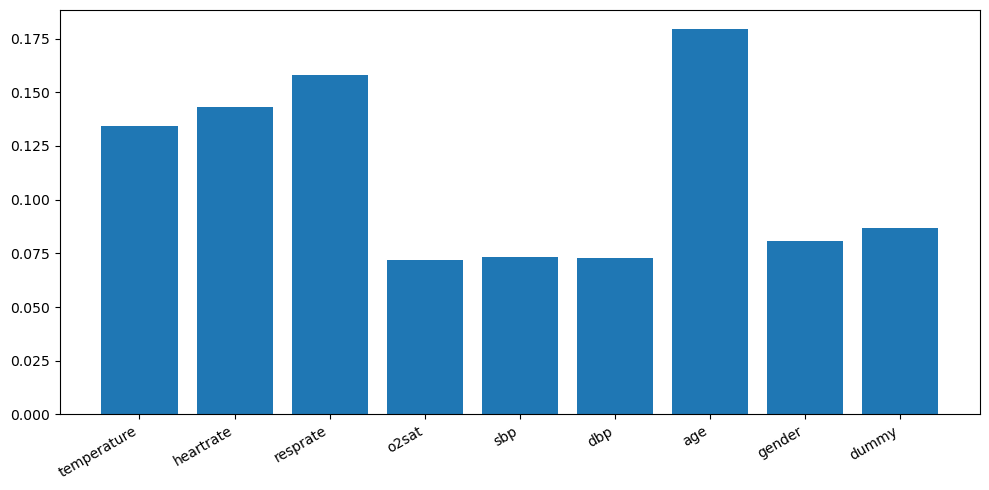

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.56142 |  0:00:00s
epoch 1  | loss: 1.13857 |  0:00:00s
epoch 2  | loss: 0.95827 |  0:00:00s
epoch 3  | loss: 0.79151 |  0:00:00s
epoch 4  | loss: 0.74827 |  0:00:00s
epoch 5  | loss: 0.6812  |  0:00:00s
epoch 6  | loss: 0.66265 |  0:00:00s
epoch 7  | loss: 0.638   |  0:00:00s
epoch 8  | loss: 0.63872 |  0:00:00s
epoch 9  | loss: 0.61298 |  0:00:00s
epoch 10 | loss: 0.59071 |  0:00:00s
epoch 11 | loss: 0.57384 |  0:00:00s
epoch 12 | loss: 0.56517 |  0:00:00s
epoch 13 | loss: 0.54016 |  0:00:00s
epoch 14 | loss: 0.55405 |  0:00:00s
epoch 15 | loss: 0.53977 |  0:00:00s
epoch 16 | loss: 0.53982 |  0:00:00s
epoch 17 | loss: 0.52077 |  0:00:00s
epoch 18 | loss: 0.51334 |  0:00:00s
epoch 19 | loss: 0.51393 |  0:00:00s
epoch 20 | loss: 0.52138 |  0:00:00s
epoch 21 | loss: 0.50077 |  0:00:00s
epoch 22 | loss: 0.4801  |  0:00:00s
epoch 23 | loss: 0.48062 |  0:00:00s
epoch 24 | loss: 0.47181 |  0:00:00s
epoch 25 | loss: 0.46547 |  0:00:00s
epoch 26 | loss: 0.44704 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 5  | loss: 0.6812  |  0:00:00s
epoch 6  | loss: 0.66265 |  0:00:00s
epoch 7  | loss: 0.638   |  0:00:00s
epoch 8  | loss: 0.63872 |  0:00:00s
epoch 9  | loss: 0.61298 |  0:00:00s
epoch 10 | loss: 0.59071 |  0:00:00s
epoch 11 | loss: 0.57384 |  0:00:00s
epoch 12 | loss: 0.56517 |  0:00:00s
epoch 13 | loss: 0.54016 |  0:00:00s
epoch 14 | loss: 0.55405 |  0:00:00s
epoch 15 | loss: 0.53977 |  0:00:00s
epoch 16 | loss: 0.53982 |  0:00:00s
epoch 17 | loss: 0.52077 |  0:00:00s
epoch 18 | loss: 0.51334 |  0:00:00s
epoch 19 | loss: 0.51393 |  0:00:00s
epoch 20 | loss: 0.52138 |  0:00:00s
epoch 21 | loss: 0.50077 |  0:00:00s
epoch 22 | loss: 0.4801  |  0:00:00s
epoch 23 | loss: 0.48062 |  0:00:00s
epoch 24 | loss: 0.47181 |  0:00:00s
epoch 25 | loss: 0.46547 |  0:00:00s
epoch 26 | loss: 0.44704 |  0:00:00s
epoch 27 | loss: 0.43969 |  0:00:00s
epoch 28 | loss: 0.46251 |  0:00:00s
epoch 29 | loss: 0.43253 |  0:00:00s
epoch 30 | loss: 0.44582 |  0:00:00s
epoch 31 | loss: 0.47155 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 6  | loss: 0.66265 |  0:00:00s
epoch 7  | loss: 0.638   |  0:00:00s
epoch 8  | loss: 0.63872 |  0:00:00s
epoch 9  | loss: 0.61298 |  0:00:00s
epoch 10 | loss: 0.59071 |  0:00:00s
epoch 11 | loss: 0.57384 |  0:00:00s
epoch 12 | loss: 0.56517 |  0:00:00s
epoch 13 | loss: 0.54016 |  0:00:00s
epoch 14 | loss: 0.55405 |  0:00:00s
epoch 15 | loss: 0.53977 |  0:00:00s
epoch 16 | loss: 0.53982 |  0:00:00s
epoch 17 | loss: 0.52077 |  0:00:00s
epoch 18 | loss: 0.51334 |  0:00:00s
epoch 19 | loss: 0.51393 |  0:00:00s
epoch 20 | loss: 0.52138 |  0:00:00s
epoch 21 | loss: 0.50077 |  0:00:00s
epoch 22 | loss: 0.4801  |  0:00:00s
epoch 23 | loss: 0.48062 |  0:00:00s
epoch 24 | loss: 0.47181 |  0:00:00s
epoch 25 | loss: 0.46547 |  0:00:00s
epoch 26 | loss: 0.44704 |  0:00:00s
epoch 27 | loss: 0.43969 |  0:00:00s
epoch 28 | loss: 0.46251 |  0:00:00s
epoch 29 | loss: 0.43253 |  0:00:00s
epoch 30 | loss: 0.44582 |  0:00:00s
epoch 31 | loss: 0.47155 |  0:00:00s
epoch 32 | loss: 0.40717 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 10 | loss: 0.59071 |  0:00:00s
epoch 11 | loss: 0.57384 |  0:00:00s
epoch 12 | loss: 0.56517 |  0:00:00s
epoch 13 | loss: 0.54016 |  0:00:00s
epoch 14 | loss: 0.55405 |  0:00:00s
epoch 15 | loss: 0.53977 |  0:00:00s
epoch 16 | loss: 0.53982 |  0:00:00s
epoch 17 | loss: 0.52077 |  0:00:00s
epoch 18 | loss: 0.51334 |  0:00:00s
epoch 19 | loss: 0.51393 |  0:00:00s
epoch 20 | loss: 0.52138 |  0:00:00s
epoch 21 | loss: 0.50077 |  0:00:00s
epoch 22 | loss: 0.4801  |  0:00:00s
epoch 23 | loss: 0.48062 |  0:00:00s
epoch 24 | loss: 0.47181 |  0:00:00s
epoch 25 | loss: 0.46547 |  0:00:00s
epoch 26 | loss: 0.44704 |  0:00:00s
epoch 27 | loss: 0.43969 |  0:00:00s
epoch 28 | loss: 0.46251 |  0:00:00s
epoch 29 | loss: 0.43253 |  0:00:00s
epoch 30 | loss: 0.44582 |  0:00:00s
epoch 31 | loss: 0.47155 |  0:00:00s
epoch 32 | loss: 0.40717 |  0:00:00s
epoch 33 | loss: 0.42145 |  0:00:00s
epoch 34 | loss: 0.38875 |  0:00:00s
epoch 35 | loss: 0.39156 |  0:00:00s
epoch 36 | loss: 0.40438 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.56142 |  0:00:00s
epoch 1  | loss: 1.13857 |  0:00:00s
epoch 2  | loss: 0.95827 |  0:00:00s
epoch 3  | loss: 0.79151 |  0:00:00s
epoch 4  | loss: 0.74827 |  0:00:00s
epoch 5  | loss: 0.6812  |  0:00:00s
epoch 6  | loss: 0.66265 |  0:00:00s
epoch 7  | loss: 0.638   |  0:00:00s
epoch 8  | loss: 0.63872 |  0:00:00s
epoch 9  | loss: 0.61298 |  0:00:00s
epoch 10 | loss: 0.59071 |  0:00:00s
epoch 11 | loss: 0.57384 |  0:00:00s
epoch 12 | loss: 0.56517 |  0:00:00s
epoch 13 | loss: 0.54016 |  0:00:00s
epoch 14 | loss: 0.55405 |  0:00:00s
epoch 15 | loss: 0.53977 |  0:00:00s
epoch 16 | loss: 0.53982 |  0:00:00s
epoch 17 | loss: 0.52077 |  0:00:00s
epoch 18 | loss: 0.51334 |  0:00:00s
epoch 19 | loss: 0.51393 |  0:00:00s
epoch 20 | loss: 0.52138 |  0:00:00s
epoch 21 | loss: 0.50077 |  0:00:00s
epoch 22 | loss: 0.4801  |  0:00:00s
epoch 23 | loss: 0.48062 |  0:00:00s
epoch 24 | loss: 0.47181 |  0:00:00s
epoch 25 | loss: 0.46547 |  0:00:00s
epoch 26 | loss: 0.44704 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 10 | loss: 0.59071 |  0:00:00s
epoch 11 | loss: 0.57384 |  0:00:00s
epoch 12 | loss: 0.56517 |  0:00:00s
epoch 13 | loss: 0.54016 |  0:00:00s
epoch 14 | loss: 0.55405 |  0:00:00s
epoch 15 | loss: 0.53977 |  0:00:00s
epoch 16 | loss: 0.53982 |  0:00:00s
epoch 17 | loss: 0.52077 |  0:00:00s
epoch 18 | loss: 0.51334 |  0:00:00s
epoch 19 | loss: 0.51393 |  0:00:00s
epoch 20 | loss: 0.52138 |  0:00:00s
epoch 21 | loss: 0.50077 |  0:00:00s
epoch 22 | loss: 0.4801  |  0:00:00s
epoch 23 | loss: 0.48062 |  0:00:00s
epoch 24 | loss: 0.47181 |  0:00:00s
epoch 25 | loss: 0.46547 |  0:00:00s
epoch 26 | loss: 0.44704 |  0:00:00s
epoch 27 | loss: 0.43969 |  0:00:00s
epoch 28 | loss: 0.46251 |  0:00:00s
epoch 29 | loss: 0.43253 |  0:00:00s
epoch 30 | loss: 0.44582 |  0:00:00s
epoch 31 | loss: 0.47155 |  0:00:00s
epoch 32 | loss: 0.40717 |  0:00:00s
epoch 33 | loss: 0.42145 |  0:00:00s
epoch 34 | loss: 0.38875 |  0:00:00s
epoch 35 | loss: 0.39156 |  0:00:00s
epoch 36 | loss: 0.40438 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 12 | loss: 0.56517 |  0:00:00s
epoch 13 | loss: 0.54016 |  0:00:00s
epoch 14 | loss: 0.55405 |  0:00:00s
epoch 15 | loss: 0.53977 |  0:00:00s
epoch 16 | loss: 0.53982 |  0:00:00s
epoch 17 | loss: 0.52077 |  0:00:00s
epoch 18 | loss: 0.51334 |  0:00:00s
epoch 19 | loss: 0.51393 |  0:00:00s
epoch 20 | loss: 0.52138 |  0:00:00s
epoch 21 | loss: 0.50077 |  0:00:00s
epoch 22 | loss: 0.4801  |  0:00:00s
epoch 23 | loss: 0.48062 |  0:00:00s
epoch 24 | loss: 0.47181 |  0:00:00s
epoch 25 | loss: 0.46547 |  0:00:00s
epoch 26 | loss: 0.44704 |  0:00:00s
epoch 27 | loss: 0.43969 |  0:00:00s
epoch 28 | loss: 0.46251 |  0:00:00s
epoch 29 | loss: 0.43253 |  0:00:00s
epoch 30 | loss: 0.44582 |  0:00:00s
epoch 31 | loss: 0.47155 |  0:00:00s
epoch 32 | loss: 0.40717 |  0:00:00s
epoch 33 | loss: 0.42145 |  0:00:00s
epoch 34 | loss: 0.38875 |  0:00:00s
epoch 35 | loss: 0.39156 |  0:00:00s
epoch 36 | loss: 0.40438 |  0:00:00s
epoch 37 | loss: 0.39907 |  0:00:00s
epoch 38 | loss: 0.38237 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 3  | loss: 0.79151 |  0:00:00s
epoch 4  | loss: 0.74827 |  0:00:00s
epoch 5  | loss: 0.6812  |  0:00:00s
epoch 6  | loss: 0.66265 |  0:00:00s
epoch 7  | loss: 0.638   |  0:00:00s
epoch 8  | loss: 0.63872 |  0:00:00s
epoch 9  | loss: 0.61298 |  0:00:00s
epoch 10 | loss: 0.59071 |  0:00:00s
epoch 11 | loss: 0.57384 |  0:00:00s
epoch 12 | loss: 0.56517 |  0:00:00s
epoch 13 | loss: 0.54016 |  0:00:00s
epoch 14 | loss: 0.55405 |  0:00:00s
epoch 15 | loss: 0.53977 |  0:00:00s
epoch 16 | loss: 0.53982 |  0:00:00s
epoch 17 | loss: 0.52077 |  0:00:00s
epoch 18 | loss: 0.51334 |  0:00:00s
epoch 19 | loss: 0.51393 |  0:00:00s
epoch 20 | loss: 0.52138 |  0:00:00s
epoch 21 | loss: 0.50077 |  0:00:00s
epoch 22 | loss: 0.4801  |  0:00:00s
epoch 23 | loss: 0.48062 |  0:00:00s
epoch 24 | loss: 0.47181 |  0:00:00s
epoch 25 | loss: 0.46547 |  0:00:00s
epoch 26 | loss: 0.44704 |  0:00:00s
epoch 27 | loss: 0.43969 |  0:00:00s
epoch 28 | loss: 0.46251 |  0:00:00s
epoch 29 | loss: 0.43253 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 7  | loss: 0.638   |  0:00:00s
epoch 8  | loss: 0.63872 |  0:00:00s
epoch 9  | loss: 0.61298 |  0:00:00s
epoch 10 | loss: 0.59071 |  0:00:00s
epoch 11 | loss: 0.57384 |  0:00:00s
epoch 12 | loss: 0.56517 |  0:00:00s
epoch 13 | loss: 0.54016 |  0:00:00s
epoch 14 | loss: 0.55405 |  0:00:00s
epoch 15 | loss: 0.53977 |  0:00:00s
epoch 16 | loss: 0.53982 |  0:00:00s
epoch 17 | loss: 0.52077 |  0:00:00s
epoch 18 | loss: 0.51334 |  0:00:00s
epoch 19 | loss: 0.51393 |  0:00:00s
epoch 20 | loss: 0.52138 |  0:00:00s
epoch 21 | loss: 0.50077 |  0:00:00s
epoch 22 | loss: 0.4801  |  0:00:00s
epoch 23 | loss: 0.48062 |  0:00:00s
epoch 24 | loss: 0.47181 |  0:00:00s
epoch 25 | loss: 0.46547 |  0:00:00s
epoch 26 | loss: 0.44704 |  0:00:00s
epoch 27 | loss: 0.43969 |  0:00:00s
epoch 28 | loss: 0.46251 |  0:00:00s
epoch 29 | loss: 0.43253 |  0:00:00s
epoch 30 | loss: 0.44582 |  0:00:00s
epoch 31 | loss: 0.47155 |  0:00:00s
epoch 32 | loss: 0.40717 |  0:00:00s
epoch 33 | loss: 0.42145 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 12 | loss: 0.56517 |  0:00:00s
epoch 13 | loss: 0.54016 |  0:00:00s
epoch 14 | loss: 0.55405 |  0:00:00s
epoch 15 | loss: 0.53977 |  0:00:00s
epoch 16 | loss: 0.53982 |  0:00:00s
epoch 17 | loss: 0.52077 |  0:00:00s
epoch 18 | loss: 0.51334 |  0:00:00s
epoch 19 | loss: 0.51393 |  0:00:00s
epoch 20 | loss: 0.52138 |  0:00:00s
epoch 21 | loss: 0.50077 |  0:00:00s
epoch 22 | loss: 0.4801  |  0:00:00s
epoch 23 | loss: 0.48062 |  0:00:00s
epoch 24 | loss: 0.47181 |  0:00:00s
epoch 25 | loss: 0.46547 |  0:00:00s
epoch 26 | loss: 0.44704 |  0:00:00s
epoch 27 | loss: 0.43969 |  0:00:00s
epoch 28 | loss: 0.46251 |  0:00:00s
epoch 29 | loss: 0.43253 |  0:00:00s
epoch 30 | loss: 0.44582 |  0:00:00s
epoch 31 | loss: 0.47155 |  0:00:00s
epoch 32 | loss: 0.40717 |  0:00:00s
epoch 33 | loss: 0.42145 |  0:00:00s
epoch 34 | loss: 0.38875 |  0:00:00s
epoch 35 | loss: 0.39156 |  0:00:00s
epoch 36 | loss: 0.40438 |  0:00:00s
epoch 37 | loss: 0.39907 |  0:00:00s
epoch 38 | loss: 0.38237 |  0:00:00s
e

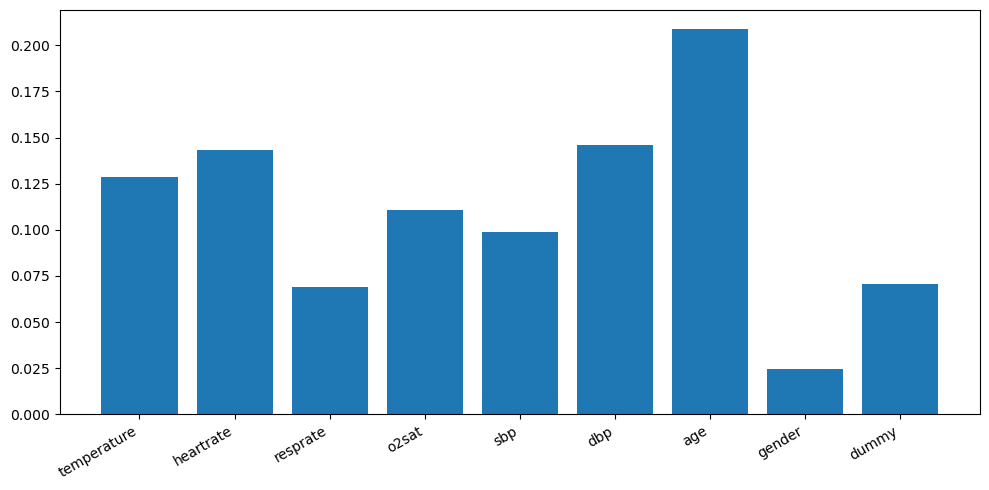

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.48627 |  0:00:00s
epoch 1  | loss: 1.33424 |  0:00:00s
epoch 2  | loss: 1.04005 |  0:00:00s
epoch 3  | loss: 0.82655 |  0:00:00s
epoch 4  | loss: 0.71636 |  0:00:00s
epoch 5  | loss: 0.63905 |  0:00:00s
epoch 6  | loss: 0.63536 |  0:00:00s
epoch 7  | loss: 0.60672 |  0:00:00s
epoch 8  | loss: 0.57047 |  0:00:00s
epoch 9  | loss: 0.58258 |  0:00:00s
epoch 10 | loss: 0.56222 |  0:00:00s
epoch 11 | loss: 0.53569 |  0:00:00s
epoch 12 | loss: 0.5222  |  0:00:00s
epoch 13 | loss: 0.50449 |  0:00:00s
epoch 14 | loss: 0.52841 |  0:00:00s
epoch 15 | loss: 0.50237 |  0:00:00s
epoch 16 | loss: 0.48051 |  0:00:00s
epoch 17 | loss: 0.46919 |  0:00:00s
epoch 18 | loss: 0.45343 |  0:00:00s
epoch 19 | loss: 0.42616 |  0:00:00s
epoch 20 | loss: 0.40623 |  0:00:00s
epoch 21 | loss: 0.40822 |  0:00:00s
epoch 22 | loss: 0.40508 |  0:00:00s
epoch 23 | loss: 0.3625  |  0:00:00s
epoch 24 | loss: 0.38135 |  0:00:00s
epoch 25 | loss: 0.40899 |  0:00:00s
epoch 26 | loss: 0.35914 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 14 | loss: 0.52841 |  0:00:00s
epoch 15 | loss: 0.50237 |  0:00:00s
epoch 16 | loss: 0.48051 |  0:00:00s
epoch 17 | loss: 0.46919 |  0:00:00s
epoch 18 | loss: 0.45343 |  0:00:00s
epoch 19 | loss: 0.42616 |  0:00:00s
epoch 20 | loss: 0.40623 |  0:00:00s
epoch 21 | loss: 0.40822 |  0:00:00s
epoch 22 | loss: 0.40508 |  0:00:00s
epoch 23 | loss: 0.3625  |  0:00:00s
epoch 24 | loss: 0.38135 |  0:00:00s
epoch 25 | loss: 0.40899 |  0:00:00s
epoch 26 | loss: 0.35914 |  0:00:00s
epoch 27 | loss: 0.39138 |  0:00:00s
epoch 28 | loss: 0.37051 |  0:00:00s
epoch 29 | loss: 0.34144 |  0:00:00s
epoch 30 | loss: 0.3287  |  0:00:00s
epoch 31 | loss: 0.31411 |  0:00:00s
epoch 32 | loss: 0.32356 |  0:00:00s
epoch 33 | loss: 0.31377 |  0:00:00s
epoch 34 | loss: 0.32579 |  0:00:00s
epoch 35 | loss: 0.40105 |  0:00:00s
epoch 36 | loss: 0.2965  |  0:00:00s
epoch 37 | loss: 0.3158  |  0:00:00s
epoch 38 | loss: 0.26611 |  0:00:00s
epoch 39 | loss: 0.294   |  0:00:00s
epoch 40 | loss: 0.27878 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 10 | loss: 0.56222 |  0:00:00s
epoch 11 | loss: 0.53569 |  0:00:00s
epoch 12 | loss: 0.5222  |  0:00:00s
epoch 13 | loss: 0.50449 |  0:00:00s
epoch 14 | loss: 0.52841 |  0:00:00s
epoch 15 | loss: 0.50237 |  0:00:00s
epoch 16 | loss: 0.48051 |  0:00:00s
epoch 17 | loss: 0.46919 |  0:00:00s
epoch 18 | loss: 0.45343 |  0:00:00s
epoch 19 | loss: 0.42616 |  0:00:00s
epoch 20 | loss: 0.40623 |  0:00:00s
epoch 21 | loss: 0.40822 |  0:00:00s
epoch 22 | loss: 0.40508 |  0:00:00s
epoch 23 | loss: 0.3625  |  0:00:00s
epoch 24 | loss: 0.38135 |  0:00:00s
epoch 25 | loss: 0.40899 |  0:00:00s
epoch 26 | loss: 0.35914 |  0:00:00s
epoch 27 | loss: 0.39138 |  0:00:00s
epoch 28 | loss: 0.37051 |  0:00:00s
epoch 29 | loss: 0.34144 |  0:00:00s
epoch 30 | loss: 0.3287  |  0:00:00s
epoch 31 | loss: 0.31411 |  0:00:00s
epoch 32 | loss: 0.32356 |  0:00:00s
epoch 33 | loss: 0.31377 |  0:00:00s
epoch 34 | loss: 0.32579 |  0:00:00s
epoch 35 | loss: 0.40105 |  0:00:00s
epoch 36 | loss: 0.2965  |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 10 | loss: 0.56222 |  0:00:00s
epoch 11 | loss: 0.53569 |  0:00:00s
epoch 12 | loss: 0.5222  |  0:00:00s
epoch 13 | loss: 0.50449 |  0:00:00s
epoch 14 | loss: 0.52841 |  0:00:00s
epoch 15 | loss: 0.50237 |  0:00:00s
epoch 16 | loss: 0.48051 |  0:00:00s
epoch 17 | loss: 0.46919 |  0:00:00s
epoch 18 | loss: 0.45343 |  0:00:00s
epoch 19 | loss: 0.42616 |  0:00:00s
epoch 20 | loss: 0.40623 |  0:00:00s
epoch 21 | loss: 0.40822 |  0:00:00s
epoch 22 | loss: 0.40508 |  0:00:00s
epoch 23 | loss: 0.3625  |  0:00:00s
epoch 24 | loss: 0.38135 |  0:00:00s
epoch 25 | loss: 0.40899 |  0:00:00s
epoch 26 | loss: 0.35914 |  0:00:00s
epoch 27 | loss: 0.39138 |  0:00:00s
epoch 28 | loss: 0.37051 |  0:00:00s
epoch 29 | loss: 0.34144 |  0:00:00s
epoch 30 | loss: 0.3287  |  0:00:00s
epoch 31 | loss: 0.31411 |  0:00:00s
epoch 32 | loss: 0.32356 |  0:00:00s
epoch 33 | loss: 0.31377 |  0:00:00s
epoch 34 | loss: 0.32579 |  0:00:00s
epoch 35 | loss: 0.40105 |  0:00:00s
epoch 36 | loss: 0.2965  |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 13 | loss: 0.50449 |  0:00:00s
epoch 14 | loss: 0.52841 |  0:00:00s
epoch 15 | loss: 0.50237 |  0:00:00s
epoch 16 | loss: 0.48051 |  0:00:00s
epoch 17 | loss: 0.46919 |  0:00:00s
epoch 18 | loss: 0.45343 |  0:00:00s
epoch 19 | loss: 0.42616 |  0:00:00s
epoch 20 | loss: 0.40623 |  0:00:00s
epoch 21 | loss: 0.40822 |  0:00:00s
epoch 22 | loss: 0.40508 |  0:00:00s
epoch 23 | loss: 0.3625  |  0:00:00s
epoch 24 | loss: 0.38135 |  0:00:00s
epoch 25 | loss: 0.40899 |  0:00:00s
epoch 26 | loss: 0.35914 |  0:00:00s
epoch 27 | loss: 0.39138 |  0:00:00s
epoch 28 | loss: 0.37051 |  0:00:00s
epoch 29 | loss: 0.34144 |  0:00:00s
epoch 30 | loss: 0.3287  |  0:00:00s
epoch 31 | loss: 0.31411 |  0:00:00s
epoch 32 | loss: 0.32356 |  0:00:00s
epoch 33 | loss: 0.31377 |  0:00:00s
epoch 34 | loss: 0.32579 |  0:00:00s
epoch 35 | loss: 0.40105 |  0:00:00s
epoch 36 | loss: 0.2965  |  0:00:00s
epoch 37 | loss: 0.3158  |  0:00:00s
epoch 38 | loss: 0.26611 |  0:00:00s
epoch 39 | loss: 0.294   |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 14 | loss: 0.52841 |  0:00:00s
epoch 15 | loss: 0.50237 |  0:00:00s
epoch 16 | loss: 0.48051 |  0:00:00s
epoch 17 | loss: 0.46919 |  0:00:00s
epoch 18 | loss: 0.45343 |  0:00:00s
epoch 19 | loss: 0.42616 |  0:00:00s
epoch 20 | loss: 0.40623 |  0:00:00s
epoch 21 | loss: 0.40822 |  0:00:00s
epoch 22 | loss: 0.40508 |  0:00:00s
epoch 23 | loss: 0.3625  |  0:00:00s
epoch 24 | loss: 0.38135 |  0:00:00s
epoch 25 | loss: 0.40899 |  0:00:00s
epoch 26 | loss: 0.35914 |  0:00:00s
epoch 27 | loss: 0.39138 |  0:00:00s
epoch 28 | loss: 0.37051 |  0:00:00s
epoch 29 | loss: 0.34144 |  0:00:00s
epoch 30 | loss: 0.3287  |  0:00:00s
epoch 31 | loss: 0.31411 |  0:00:00s
epoch 32 | loss: 0.32356 |  0:00:00s
epoch 33 | loss: 0.31377 |  0:00:00s
epoch 34 | loss: 0.32579 |  0:00:00s
epoch 35 | loss: 0.40105 |  0:00:00s
epoch 36 | loss: 0.2965  |  0:00:00s
epoch 37 | loss: 0.3158  |  0:00:00s
epoch 38 | loss: 0.26611 |  0:00:00s
epoch 39 | loss: 0.294   |  0:00:00s
epoch 40 | loss: 0.27878 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 11 | loss: 0.53569 |  0:00:00s
epoch 12 | loss: 0.5222  |  0:00:00s
epoch 13 | loss: 0.50449 |  0:00:00s
epoch 14 | loss: 0.52841 |  0:00:00s
epoch 15 | loss: 0.50237 |  0:00:00s
epoch 16 | loss: 0.48051 |  0:00:00s
epoch 17 | loss: 0.46919 |  0:00:00s
epoch 18 | loss: 0.45343 |  0:00:00s
epoch 19 | loss: 0.42616 |  0:00:00s
epoch 20 | loss: 0.40623 |  0:00:00s
epoch 21 | loss: 0.40822 |  0:00:00s
epoch 22 | loss: 0.40508 |  0:00:00s
epoch 23 | loss: 0.3625  |  0:00:00s
epoch 24 | loss: 0.38135 |  0:00:00s
epoch 25 | loss: 0.40899 |  0:00:00s
epoch 26 | loss: 0.35914 |  0:00:00s
epoch 27 | loss: 0.39138 |  0:00:00s
epoch 28 | loss: 0.37051 |  0:00:00s
epoch 29 | loss: 0.34144 |  0:00:00s
epoch 30 | loss: 0.3287  |  0:00:00s
epoch 31 | loss: 0.31411 |  0:00:00s
epoch 32 | loss: 0.32356 |  0:00:00s
epoch 33 | loss: 0.31377 |  0:00:00s
epoch 34 | loss: 0.32579 |  0:00:00s
epoch 35 | loss: 0.40105 |  0:00:00s
epoch 36 | loss: 0.2965  |  0:00:00s
epoch 37 | loss: 0.3158  |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.48627 |  0:00:00s
epoch 1  | loss: 1.33424 |  0:00:00s
epoch 2  | loss: 1.04005 |  0:00:00s
epoch 3  | loss: 0.82655 |  0:00:00s
epoch 4  | loss: 0.71636 |  0:00:00s
epoch 5  | loss: 0.63905 |  0:00:00s
epoch 6  | loss: 0.63536 |  0:00:00s
epoch 7  | loss: 0.60672 |  0:00:00s
epoch 8  | loss: 0.57047 |  0:00:00s
epoch 9  | loss: 0.58258 |  0:00:00s
epoch 10 | loss: 0.56222 |  0:00:00s
epoch 11 | loss: 0.53569 |  0:00:00s
epoch 12 | loss: 0.5222  |  0:00:00s
epoch 13 | loss: 0.50449 |  0:00:00s
epoch 14 | loss: 0.52841 |  0:00:00s
epoch 15 | loss: 0.50237 |  0:00:00s
epoch 16 | loss: 0.48051 |  0:00:00s
epoch 17 | loss: 0.46919 |  0:00:00s
epoch 18 | loss: 0.45343 |  0:00:00s
epoch 19 | loss: 0.42616 |  0:00:00s
epoch 20 | loss: 0.40623 |  0:00:00s
epoch 21 | loss: 0.40822 |  0:00:00s
epoch 22 | loss: 0.40508 |  0:00:00s
epoch 23 | loss: 0.3625  |  0:00:00s
epoch 24 | loss: 0.38135 |  0:00:00s
epoch 25 | loss: 0.40899 |  0:00:00s
epoch 26 | loss: 0.35914 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 9  | loss: 0.58258 |  0:00:00s
epoch 10 | loss: 0.56222 |  0:00:00s
epoch 11 | loss: 0.53569 |  0:00:00s
epoch 12 | loss: 0.5222  |  0:00:00s
epoch 13 | loss: 0.50449 |  0:00:00s
epoch 14 | loss: 0.52841 |  0:00:00s
epoch 15 | loss: 0.50237 |  0:00:00s
epoch 16 | loss: 0.48051 |  0:00:00s
epoch 17 | loss: 0.46919 |  0:00:00s
epoch 18 | loss: 0.45343 |  0:00:00s
epoch 19 | loss: 0.42616 |  0:00:00s
epoch 20 | loss: 0.40623 |  0:00:00s
epoch 21 | loss: 0.40822 |  0:00:00s
epoch 22 | loss: 0.40508 |  0:00:00s
epoch 23 | loss: 0.3625  |  0:00:00s
epoch 24 | loss: 0.38135 |  0:00:00s
epoch 25 | loss: 0.40899 |  0:00:00s
epoch 26 | loss: 0.35914 |  0:00:00s
epoch 27 | loss: 0.39138 |  0:00:00s
epoch 28 | loss: 0.37051 |  0:00:00s
epoch 29 | loss: 0.34144 |  0:00:00s
epoch 30 | loss: 0.3287  |  0:00:00s
epoch 31 | loss: 0.31411 |  0:00:00s
epoch 32 | loss: 0.32356 |  0:00:00s
epoch 33 | loss: 0.31377 |  0:00:00s
epoch 34 | loss: 0.32579 |  0:00:00s
epoch 35 | loss: 0.40105 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 9  | loss: 0.58258 |  0:00:00s
epoch 10 | loss: 0.56222 |  0:00:00s
epoch 11 | loss: 0.53569 |  0:00:00s
epoch 12 | loss: 0.5222  |  0:00:00s
epoch 13 | loss: 0.50449 |  0:00:00s
epoch 14 | loss: 0.52841 |  0:00:00s
epoch 15 | loss: 0.50237 |  0:00:00s
epoch 16 | loss: 0.48051 |  0:00:00s
epoch 17 | loss: 0.46919 |  0:00:00s
epoch 18 | loss: 0.45343 |  0:00:00s
epoch 19 | loss: 0.42616 |  0:00:00s
epoch 20 | loss: 0.40623 |  0:00:00s
epoch 21 | loss: 0.40822 |  0:00:00s
epoch 22 | loss: 0.40508 |  0:00:00s
epoch 23 | loss: 0.3625  |  0:00:00s
epoch 24 | loss: 0.38135 |  0:00:00s
epoch 25 | loss: 0.40899 |  0:00:00s
epoch 26 | loss: 0.35914 |  0:00:00s
epoch 27 | loss: 0.39138 |  0:00:00s
epoch 28 | loss: 0.37051 |  0:00:00s
epoch 29 | loss: 0.34144 |  0:00:00s
epoch 30 | loss: 0.3287  |  0:00:00s
epoch 31 | loss: 0.31411 |  0:00:00s
epoch 32 | loss: 0.32356 |  0:00:00s
epoch 33 | loss: 0.31377 |  0:00:00s
epoch 34 | loss: 0.32579 |  0:00:00s
epoch 35 | loss: 0.40105 |  0:00:00s
e

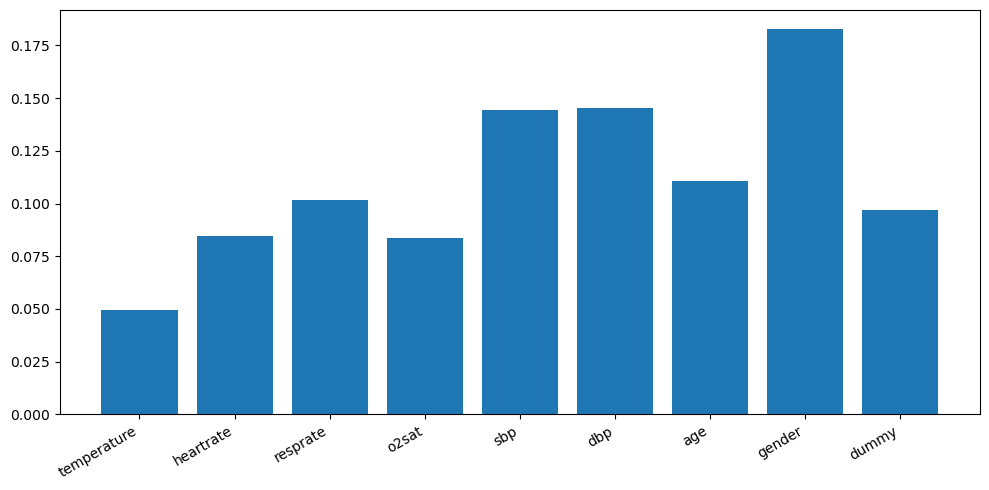

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.52413 |  0:00:00s
epoch 1  | loss: 1.12847 |  0:00:00s
epoch 2  | loss: 0.87568 |  0:00:00s
epoch 3  | loss: 0.74795 |  0:00:00s
epoch 4  | loss: 0.62716 |  0:00:00s
epoch 5  | loss: 0.62506 |  0:00:00s
epoch 6  | loss: 0.60099 |  0:00:00s
epoch 7  | loss: 0.56921 |  0:00:00s
epoch 8  | loss: 0.56    |  0:00:00s
epoch 9  | loss: 0.58577 |  0:00:00s
epoch 10 | loss: 0.56826 |  0:00:00s
epoch 11 | loss: 0.51973 |  0:00:00s
epoch 12 | loss: 0.51092 |  0:00:00s
epoch 13 | loss: 0.49791 |  0:00:00s
epoch 14 | loss: 0.50119 |  0:00:00s
epoch 15 | loss: 0.45535 |  0:00:00s
epoch 16 | loss: 0.46318 |  0:00:00s
epoch 17 | loss: 0.44904 |  0:00:00s
epoch 18 | loss: 0.4264  |  0:00:00s
epoch 19 | loss: 0.43897 |  0:00:00s
epoch 20 | loss: 0.40813 |  0:00:00s
epoch 21 | loss: 0.37711 |  0:00:00s
epoch 22 | loss: 0.3955  |  0:00:00s
epoch 23 | loss: 0.41963 |  0:00:00s
epoch 24 | loss: 0.3444  |  0:00:00s
epoch 25 | loss: 0.35784 |  0:00:00s
epoch 26 | loss: 0.33605 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 3  | loss: 0.74795 |  0:00:00s
epoch 4  | loss: 0.62716 |  0:00:00s
epoch 5  | loss: 0.62506 |  0:00:00s
epoch 6  | loss: 0.60099 |  0:00:00s
epoch 7  | loss: 0.56921 |  0:00:00s
epoch 8  | loss: 0.56    |  0:00:00s
epoch 9  | loss: 0.58577 |  0:00:00s
epoch 10 | loss: 0.56826 |  0:00:00s
epoch 11 | loss: 0.51973 |  0:00:00s
epoch 12 | loss: 0.51092 |  0:00:00s
epoch 13 | loss: 0.49791 |  0:00:00s
epoch 14 | loss: 0.50119 |  0:00:00s
epoch 15 | loss: 0.45535 |  0:00:00s
epoch 16 | loss: 0.46318 |  0:00:00s
epoch 17 | loss: 0.44904 |  0:00:00s
epoch 18 | loss: 0.4264  |  0:00:00s
epoch 19 | loss: 0.43897 |  0:00:00s
epoch 20 | loss: 0.40813 |  0:00:00s
epoch 21 | loss: 0.37711 |  0:00:00s
epoch 22 | loss: 0.3955  |  0:00:00s
epoch 23 | loss: 0.41963 |  0:00:00s
epoch 24 | loss: 0.3444  |  0:00:00s
epoch 25 | loss: 0.35784 |  0:00:00s
epoch 26 | loss: 0.33605 |  0:00:00s
epoch 27 | loss: 0.34233 |  0:00:00s
epoch 28 | loss: 0.31354 |  0:00:00s
epoch 29 | loss: 0.3065  |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 4  | loss: 0.62716 |  0:00:00s
epoch 5  | loss: 0.62506 |  0:00:00s
epoch 6  | loss: 0.60099 |  0:00:00s
epoch 7  | loss: 0.56921 |  0:00:00s
epoch 8  | loss: 0.56    |  0:00:00s
epoch 9  | loss: 0.58577 |  0:00:00s
epoch 10 | loss: 0.56826 |  0:00:00s
epoch 11 | loss: 0.51973 |  0:00:00s
epoch 12 | loss: 0.51092 |  0:00:00s
epoch 13 | loss: 0.49791 |  0:00:00s
epoch 14 | loss: 0.50119 |  0:00:00s
epoch 15 | loss: 0.45535 |  0:00:00s
epoch 16 | loss: 0.46318 |  0:00:00s
epoch 17 | loss: 0.44904 |  0:00:00s
epoch 18 | loss: 0.4264  |  0:00:00s
epoch 19 | loss: 0.43897 |  0:00:00s
epoch 20 | loss: 0.40813 |  0:00:00s
epoch 21 | loss: 0.37711 |  0:00:00s
epoch 22 | loss: 0.3955  |  0:00:00s
epoch 23 | loss: 0.41963 |  0:00:00s
epoch 24 | loss: 0.3444  |  0:00:00s
epoch 25 | loss: 0.35784 |  0:00:00s
epoch 26 | loss: 0.33605 |  0:00:00s
epoch 27 | loss: 0.34233 |  0:00:00s
epoch 28 | loss: 0.31354 |  0:00:00s
epoch 29 | loss: 0.3065  |  0:00:00s
epoch 30 | loss: 0.31395 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 8  | loss: 0.56    |  0:00:00s
epoch 9  | loss: 0.58577 |  0:00:00s
epoch 10 | loss: 0.56826 |  0:00:00s
epoch 11 | loss: 0.51973 |  0:00:00s
epoch 12 | loss: 0.51092 |  0:00:00s
epoch 13 | loss: 0.49791 |  0:00:00s
epoch 14 | loss: 0.50119 |  0:00:00s
epoch 15 | loss: 0.45535 |  0:00:00s
epoch 16 | loss: 0.46318 |  0:00:00s
epoch 17 | loss: 0.44904 |  0:00:00s
epoch 18 | loss: 0.4264  |  0:00:00s
epoch 19 | loss: 0.43897 |  0:00:00s
epoch 20 | loss: 0.40813 |  0:00:00s
epoch 21 | loss: 0.37711 |  0:00:00s
epoch 22 | loss: 0.3955  |  0:00:00s
epoch 23 | loss: 0.41963 |  0:00:00s
epoch 24 | loss: 0.3444  |  0:00:00s
epoch 25 | loss: 0.35784 |  0:00:00s
epoch 26 | loss: 0.33605 |  0:00:00s
epoch 27 | loss: 0.34233 |  0:00:00s
epoch 28 | loss: 0.31354 |  0:00:00s
epoch 29 | loss: 0.3065  |  0:00:00s
epoch 30 | loss: 0.31395 |  0:00:00s
epoch 31 | loss: 0.29362 |  0:00:00s
epoch 32 | loss: 0.28715 |  0:00:00s
epoch 33 | loss: 0.30274 |  0:00:00s
epoch 34 | loss: 0.25513 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 15 | loss: 0.45535 |  0:00:00s
epoch 16 | loss: 0.46318 |  0:00:00s
epoch 17 | loss: 0.44904 |  0:00:00s
epoch 18 | loss: 0.4264  |  0:00:00s
epoch 19 | loss: 0.43897 |  0:00:00s
epoch 20 | loss: 0.40813 |  0:00:00s
epoch 21 | loss: 0.37711 |  0:00:00s
epoch 22 | loss: 0.3955  |  0:00:00s
epoch 23 | loss: 0.41963 |  0:00:00s
epoch 24 | loss: 0.3444  |  0:00:00s
epoch 25 | loss: 0.35784 |  0:00:00s
epoch 26 | loss: 0.33605 |  0:00:00s
epoch 27 | loss: 0.34233 |  0:00:00s
epoch 28 | loss: 0.31354 |  0:00:00s
epoch 29 | loss: 0.3065  |  0:00:00s
epoch 30 | loss: 0.31395 |  0:00:00s
epoch 31 | loss: 0.29362 |  0:00:00s
epoch 32 | loss: 0.28715 |  0:00:00s
epoch 33 | loss: 0.30274 |  0:00:00s
epoch 34 | loss: 0.25513 |  0:00:00s
epoch 35 | loss: 0.28811 |  0:00:00s
epoch 36 | loss: 0.29538 |  0:00:00s
epoch 37 | loss: 0.25401 |  0:00:00s
epoch 38 | loss: 0.25846 |  0:00:00s
epoch 39 | loss: 0.26014 |  0:00:00s
epoch 40 | loss: 0.21325 |  0:00:00s
epoch 41 | loss: 0.19167 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.52413 |  0:00:00s
epoch 1  | loss: 1.12847 |  0:00:00s
epoch 2  | loss: 0.87568 |  0:00:00s
epoch 3  | loss: 0.74795 |  0:00:00s
epoch 4  | loss: 0.62716 |  0:00:00s
epoch 5  | loss: 0.62506 |  0:00:00s
epoch 6  | loss: 0.60099 |  0:00:00s
epoch 7  | loss: 0.56921 |  0:00:00s
epoch 8  | loss: 0.56    |  0:00:00s
epoch 9  | loss: 0.58577 |  0:00:00s
epoch 10 | loss: 0.56826 |  0:00:00s
epoch 11 | loss: 0.51973 |  0:00:00s
epoch 12 | loss: 0.51092 |  0:00:00s
epoch 13 | loss: 0.49791 |  0:00:00s
epoch 14 | loss: 0.50119 |  0:00:00s
epoch 15 | loss: 0.45535 |  0:00:00s
epoch 16 | loss: 0.46318 |  0:00:00s
epoch 17 | loss: 0.44904 |  0:00:00s
epoch 18 | loss: 0.4264  |  0:00:00s
epoch 19 | loss: 0.43897 |  0:00:00s
epoch 20 | loss: 0.40813 |  0:00:00s
epoch 21 | loss: 0.37711 |  0:00:00s
epoch 22 | loss: 0.3955  |  0:00:00s
epoch 23 | loss: 0.41963 |  0:00:00s
epoch 24 | loss: 0.3444  |  0:00:00s
epoch 25 | loss: 0.35784 |  0:00:00s
epoch 26 | loss: 0.33605 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 3  | loss: 0.74795 |  0:00:00s
epoch 4  | loss: 0.62716 |  0:00:00s
epoch 5  | loss: 0.62506 |  0:00:00s
epoch 6  | loss: 0.60099 |  0:00:00s
epoch 7  | loss: 0.56921 |  0:00:00s
epoch 8  | loss: 0.56    |  0:00:00s
epoch 9  | loss: 0.58577 |  0:00:00s
epoch 10 | loss: 0.56826 |  0:00:00s
epoch 11 | loss: 0.51973 |  0:00:00s
epoch 12 | loss: 0.51092 |  0:00:00s
epoch 13 | loss: 0.49791 |  0:00:00s
epoch 14 | loss: 0.50119 |  0:00:00s
epoch 15 | loss: 0.45535 |  0:00:00s
epoch 16 | loss: 0.46318 |  0:00:00s
epoch 17 | loss: 0.44904 |  0:00:00s
epoch 18 | loss: 0.4264  |  0:00:00s
epoch 19 | loss: 0.43897 |  0:00:00s
epoch 20 | loss: 0.40813 |  0:00:00s
epoch 21 | loss: 0.37711 |  0:00:00s
epoch 22 | loss: 0.3955  |  0:00:00s
epoch 23 | loss: 0.41963 |  0:00:00s
epoch 24 | loss: 0.3444  |  0:00:00s
epoch 25 | loss: 0.35784 |  0:00:00s
epoch 26 | loss: 0.33605 |  0:00:00s
epoch 27 | loss: 0.34233 |  0:00:00s
epoch 28 | loss: 0.31354 |  0:00:00s
epoch 29 | loss: 0.3065  |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 13 | loss: 0.49791 |  0:00:00s
epoch 14 | loss: 0.50119 |  0:00:00s
epoch 15 | loss: 0.45535 |  0:00:00s
epoch 16 | loss: 0.46318 |  0:00:00s
epoch 17 | loss: 0.44904 |  0:00:00s
epoch 18 | loss: 0.4264  |  0:00:00s
epoch 19 | loss: 0.43897 |  0:00:00s
epoch 20 | loss: 0.40813 |  0:00:00s
epoch 21 | loss: 0.37711 |  0:00:00s
epoch 22 | loss: 0.3955  |  0:00:00s
epoch 23 | loss: 0.41963 |  0:00:00s
epoch 24 | loss: 0.3444  |  0:00:00s
epoch 25 | loss: 0.35784 |  0:00:00s
epoch 26 | loss: 0.33605 |  0:00:00s
epoch 27 | loss: 0.34233 |  0:00:00s
epoch 28 | loss: 0.31354 |  0:00:00s
epoch 29 | loss: 0.3065  |  0:00:00s
epoch 30 | loss: 0.31395 |  0:00:00s
epoch 31 | loss: 0.29362 |  0:00:00s
epoch 32 | loss: 0.28715 |  0:00:00s
epoch 33 | loss: 0.30274 |  0:00:00s
epoch 34 | loss: 0.25513 |  0:00:00s
epoch 35 | loss: 0.28811 |  0:00:00s
epoch 36 | loss: 0.29538 |  0:00:00s
epoch 37 | loss: 0.25401 |  0:00:00s
epoch 38 | loss: 0.25846 |  0:00:00s
epoch 39 | loss: 0.26014 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 7  | loss: 0.56921 |  0:00:00s
epoch 8  | loss: 0.56    |  0:00:00s
epoch 9  | loss: 0.58577 |  0:00:00s
epoch 10 | loss: 0.56826 |  0:00:00s
epoch 11 | loss: 0.51973 |  0:00:00s
epoch 12 | loss: 0.51092 |  0:00:00s
epoch 13 | loss: 0.49791 |  0:00:00s
epoch 14 | loss: 0.50119 |  0:00:00s
epoch 15 | loss: 0.45535 |  0:00:00s
epoch 16 | loss: 0.46318 |  0:00:00s
epoch 17 | loss: 0.44904 |  0:00:00s
epoch 18 | loss: 0.4264  |  0:00:00s
epoch 19 | loss: 0.43897 |  0:00:00s
epoch 20 | loss: 0.40813 |  0:00:00s
epoch 21 | loss: 0.37711 |  0:00:00s
epoch 22 | loss: 0.3955  |  0:00:00s
epoch 23 | loss: 0.41963 |  0:00:00s
epoch 24 | loss: 0.3444  |  0:00:00s
epoch 25 | loss: 0.35784 |  0:00:00s
epoch 26 | loss: 0.33605 |  0:00:00s
epoch 27 | loss: 0.34233 |  0:00:00s
epoch 28 | loss: 0.31354 |  0:00:00s
epoch 29 | loss: 0.3065  |  0:00:00s
epoch 30 | loss: 0.31395 |  0:00:00s
epoch 31 | loss: 0.29362 |  0:00:00s
epoch 32 | loss: 0.28715 |  0:00:00s
epoch 33 | loss: 0.30274 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 7  | loss: 0.56921 |  0:00:00s
epoch 8  | loss: 0.56    |  0:00:00s
epoch 9  | loss: 0.58577 |  0:00:00s
epoch 10 | loss: 0.56826 |  0:00:00s
epoch 11 | loss: 0.51973 |  0:00:00s
epoch 12 | loss: 0.51092 |  0:00:00s
epoch 13 | loss: 0.49791 |  0:00:00s
epoch 14 | loss: 0.50119 |  0:00:00s
epoch 15 | loss: 0.45535 |  0:00:00s
epoch 16 | loss: 0.46318 |  0:00:00s
epoch 17 | loss: 0.44904 |  0:00:00s
epoch 18 | loss: 0.4264  |  0:00:00s
epoch 19 | loss: 0.43897 |  0:00:00s
epoch 20 | loss: 0.40813 |  0:00:00s
epoch 21 | loss: 0.37711 |  0:00:00s
epoch 22 | loss: 0.3955  |  0:00:00s
epoch 23 | loss: 0.41963 |  0:00:00s
epoch 24 | loss: 0.3444  |  0:00:00s
epoch 25 | loss: 0.35784 |  0:00:00s
epoch 26 | loss: 0.33605 |  0:00:00s
epoch 27 | loss: 0.34233 |  0:00:00s
epoch 28 | loss: 0.31354 |  0:00:00s
epoch 29 | loss: 0.3065  |  0:00:00s
epoch 30 | loss: 0.31395 |  0:00:00s
epoch 31 | loss: 0.29362 |  0:00:00s
epoch 32 | loss: 0.28715 |  0:00:00s
epoch 33 | loss: 0.30274 |  0:00:00s
e

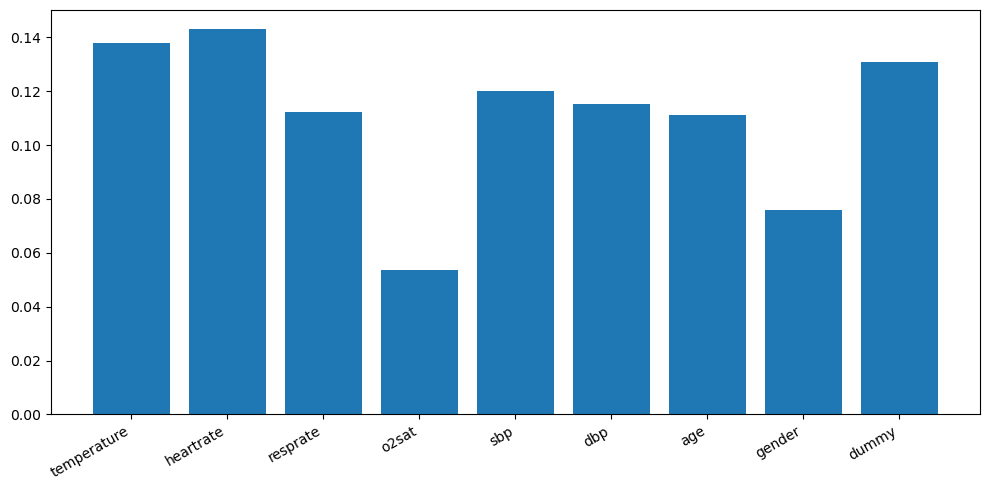

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.38635 |  0:00:00s
epoch 1  | loss: 1.00066 |  0:00:00s
epoch 2  | loss: 0.83294 |  0:00:00s
epoch 3  | loss: 0.72425 |  0:00:00s
epoch 4  | loss: 0.69895 |  0:00:00s
epoch 5  | loss: 0.68311 |  0:00:00s
epoch 6  | loss: 0.67519 |  0:00:00s
epoch 7  | loss: 0.61755 |  0:00:00s
epoch 8  | loss: 0.59845 |  0:00:00s
epoch 9  | loss: 0.56215 |  0:00:00s
epoch 10 | loss: 0.5324  |  0:00:00s
epoch 11 | loss: 0.5249  |  0:00:00s
epoch 12 | loss: 0.50437 |  0:00:00s
epoch 13 | loss: 0.4893  |  0:00:00s
epoch 14 | loss: 0.4954  |  0:00:00s
epoch 15 | loss: 0.47502 |  0:00:00s
epoch 16 | loss: 0.52448 |  0:00:00s
epoch 17 | loss: 0.48797 |  0:00:00s
epoch 18 | loss: 0.46272 |  0:00:00s
epoch 19 | loss: 0.45256 |  0:00:00s
epoch 20 | loss: 0.50866 |  0:00:00s
epoch 21 | loss: 0.44426 |  0:00:00s
epoch 22 | loss: 0.41612 |  0:00:00s
epoch 23 | loss: 0.42473 |  0:00:00s
epoch 24 | loss: 0.41056 |  0:00:00s
epoch 25 | loss: 0.42724 |  0:00:00s
epoch 26 | loss: 0.42498 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.38635 |  0:00:00s
epoch 1  | loss: 1.00066 |  0:00:00s
epoch 2  | loss: 0.83294 |  0:00:00s
epoch 3  | loss: 0.72425 |  0:00:00s
epoch 4  | loss: 0.69895 |  0:00:00s
epoch 5  | loss: 0.68311 |  0:00:00s
epoch 6  | loss: 0.67519 |  0:00:00s
epoch 7  | loss: 0.61755 |  0:00:00s
epoch 8  | loss: 0.59845 |  0:00:00s
epoch 9  | loss: 0.56215 |  0:00:00s
epoch 10 | loss: 0.5324  |  0:00:00s
epoch 11 | loss: 0.5249  |  0:00:00s
epoch 12 | loss: 0.50437 |  0:00:00s
epoch 13 | loss: 0.4893  |  0:00:00s
epoch 14 | loss: 0.4954  |  0:00:00s
epoch 15 | loss: 0.47502 |  0:00:00s
epoch 16 | loss: 0.52448 |  0:00:00s
epoch 17 | loss: 0.48797 |  0:00:00s
epoch 18 | loss: 0.46272 |  0:00:00s
epoch 19 | loss: 0.45256 |  0:00:00s
epoch 20 | loss: 0.50866 |  0:00:00s
epoch 21 | loss: 0.44426 |  0:00:00s
epoch 22 | loss: 0.41612 |  0:00:00s
epoch 23 | loss: 0.42473 |  0:00:00s
epoch 24 | loss: 0.41056 |  0:00:00s
epoch 25 | loss: 0.42724 |  0:00:00s
epoch 26 | loss: 0.42498 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 8  | loss: 0.59845 |  0:00:00s
epoch 9  | loss: 0.56215 |  0:00:00s
epoch 10 | loss: 0.5324  |  0:00:00s
epoch 11 | loss: 0.5249  |  0:00:00s
epoch 12 | loss: 0.50437 |  0:00:00s
epoch 13 | loss: 0.4893  |  0:00:00s
epoch 14 | loss: 0.4954  |  0:00:00s
epoch 15 | loss: 0.47502 |  0:00:00s
epoch 16 | loss: 0.52448 |  0:00:00s
epoch 17 | loss: 0.48797 |  0:00:00s
epoch 18 | loss: 0.46272 |  0:00:00s
epoch 19 | loss: 0.45256 |  0:00:00s
epoch 20 | loss: 0.50866 |  0:00:00s
epoch 21 | loss: 0.44426 |  0:00:00s
epoch 22 | loss: 0.41612 |  0:00:00s
epoch 23 | loss: 0.42473 |  0:00:00s
epoch 24 | loss: 0.41056 |  0:00:00s
epoch 25 | loss: 0.42724 |  0:00:00s
epoch 26 | loss: 0.42498 |  0:00:00s
epoch 27 | loss: 0.42622 |  0:00:00s
epoch 28 | loss: 0.40103 |  0:00:00s
epoch 29 | loss: 0.40006 |  0:00:00s
epoch 30 | loss: 0.37836 |  0:00:00s
epoch 31 | loss: 0.40943 |  0:00:00s
epoch 32 | loss: 0.43785 |  0:00:00s
epoch 33 | loss: 0.44482 |  0:00:00s
epoch 34 | loss: 0.40521 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 7  | loss: 0.61755 |  0:00:00s
epoch 8  | loss: 0.59845 |  0:00:00s
epoch 9  | loss: 0.56215 |  0:00:00s
epoch 10 | loss: 0.5324  |  0:00:00s
epoch 11 | loss: 0.5249  |  0:00:00s
epoch 12 | loss: 0.50437 |  0:00:00s
epoch 13 | loss: 0.4893  |  0:00:00s
epoch 14 | loss: 0.4954  |  0:00:00s
epoch 15 | loss: 0.47502 |  0:00:00s
epoch 16 | loss: 0.52448 |  0:00:00s
epoch 17 | loss: 0.48797 |  0:00:00s
epoch 18 | loss: 0.46272 |  0:00:00s
epoch 19 | loss: 0.45256 |  0:00:00s
epoch 20 | loss: 0.50866 |  0:00:00s
epoch 21 | loss: 0.44426 |  0:00:00s
epoch 22 | loss: 0.41612 |  0:00:00s
epoch 23 | loss: 0.42473 |  0:00:00s
epoch 24 | loss: 0.41056 |  0:00:00s
epoch 25 | loss: 0.42724 |  0:00:00s
epoch 26 | loss: 0.42498 |  0:00:00s
epoch 27 | loss: 0.42622 |  0:00:00s
epoch 28 | loss: 0.40103 |  0:00:00s
epoch 29 | loss: 0.40006 |  0:00:00s
epoch 30 | loss: 0.37836 |  0:00:00s
epoch 31 | loss: 0.40943 |  0:00:00s
epoch 32 | loss: 0.43785 |  0:00:00s
epoch 33 | loss: 0.44482 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.38635 |  0:00:00s
epoch 1  | loss: 1.00066 |  0:00:00s
epoch 2  | loss: 0.83294 |  0:00:00s
epoch 3  | loss: 0.72425 |  0:00:00s
epoch 4  | loss: 0.69895 |  0:00:00s
epoch 5  | loss: 0.68311 |  0:00:00s
epoch 6  | loss: 0.67519 |  0:00:00s
epoch 7  | loss: 0.61755 |  0:00:00s
epoch 8  | loss: 0.59845 |  0:00:00s
epoch 9  | loss: 0.56215 |  0:00:00s
epoch 10 | loss: 0.5324  |  0:00:00s
epoch 11 | loss: 0.5249  |  0:00:00s
epoch 12 | loss: 0.50437 |  0:00:00s
epoch 13 | loss: 0.4893  |  0:00:00s
epoch 14 | loss: 0.4954  |  0:00:00s
epoch 15 | loss: 0.47502 |  0:00:00s
epoch 16 | loss: 0.52448 |  0:00:00s
epoch 17 | loss: 0.48797 |  0:00:00s
epoch 18 | loss: 0.46272 |  0:00:00s
epoch 19 | loss: 0.45256 |  0:00:00s
epoch 20 | loss: 0.50866 |  0:00:00s
epoch 21 | loss: 0.44426 |  0:00:00s
epoch 22 | loss: 0.41612 |  0:00:00s
epoch 23 | loss: 0.42473 |  0:00:00s
epoch 24 | loss: 0.41056 |  0:00:00s
epoch 25 | loss: 0.42724 |  0:00:00s
epoch 26 | loss: 0.42498 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.38635 |  0:00:00s
epoch 1  | loss: 1.00066 |  0:00:00s
epoch 2  | loss: 0.83294 |  0:00:00s
epoch 3  | loss: 0.72425 |  0:00:00s
epoch 4  | loss: 0.69895 |  0:00:00s
epoch 5  | loss: 0.68311 |  0:00:00s
epoch 6  | loss: 0.67519 |  0:00:00s
epoch 7  | loss: 0.61755 |  0:00:00s
epoch 8  | loss: 0.59845 |  0:00:00s
epoch 9  | loss: 0.56215 |  0:00:00s
epoch 10 | loss: 0.5324  |  0:00:00s
epoch 11 | loss: 0.5249  |  0:00:00s
epoch 12 | loss: 0.50437 |  0:00:00s
epoch 13 | loss: 0.4893  |  0:00:00s
epoch 14 | loss: 0.4954  |  0:00:00s
epoch 15 | loss: 0.47502 |  0:00:00s
epoch 16 | loss: 0.52448 |  0:00:00s
epoch 17 | loss: 0.48797 |  0:00:00s
epoch 18 | loss: 0.46272 |  0:00:00s
epoch 19 | loss: 0.45256 |  0:00:00s
epoch 20 | loss: 0.50866 |  0:00:00s
epoch 21 | loss: 0.44426 |  0:00:00s
epoch 22 | loss: 0.41612 |  0:00:00s
epoch 23 | loss: 0.42473 |  0:00:00s
epoch 24 | loss: 0.41056 |  0:00:00s
epoch 25 | loss: 0.42724 |  0:00:00s
epoch 26 | loss: 0.42498 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 9  | loss: 0.56215 |  0:00:00s
epoch 10 | loss: 0.5324  |  0:00:00s
epoch 11 | loss: 0.5249  |  0:00:00s
epoch 12 | loss: 0.50437 |  0:00:00s
epoch 13 | loss: 0.4893  |  0:00:00s
epoch 14 | loss: 0.4954  |  0:00:00s
epoch 15 | loss: 0.47502 |  0:00:00s
epoch 16 | loss: 0.52448 |  0:00:00s
epoch 17 | loss: 0.48797 |  0:00:00s
epoch 18 | loss: 0.46272 |  0:00:00s
epoch 19 | loss: 0.45256 |  0:00:00s
epoch 20 | loss: 0.50866 |  0:00:00s
epoch 21 | loss: 0.44426 |  0:00:00s
epoch 22 | loss: 0.41612 |  0:00:00s
epoch 23 | loss: 0.42473 |  0:00:00s
epoch 24 | loss: 0.41056 |  0:00:00s
epoch 25 | loss: 0.42724 |  0:00:00s
epoch 26 | loss: 0.42498 |  0:00:00s
epoch 27 | loss: 0.42622 |  0:00:00s
epoch 28 | loss: 0.40103 |  0:00:00s
epoch 29 | loss: 0.40006 |  0:00:00s
epoch 30 | loss: 0.37836 |  0:00:00s
epoch 31 | loss: 0.40943 |  0:00:00s
epoch 32 | loss: 0.43785 |  0:00:00s
epoch 33 | loss: 0.44482 |  0:00:00s
epoch 34 | loss: 0.40521 |  0:00:00s
epoch 35 | loss: 0.36496 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 14 | loss: 0.4954  |  0:00:00s
epoch 15 | loss: 0.47502 |  0:00:00s
epoch 16 | loss: 0.52448 |  0:00:00s
epoch 17 | loss: 0.48797 |  0:00:00s
epoch 18 | loss: 0.46272 |  0:00:00s
epoch 19 | loss: 0.45256 |  0:00:00s
epoch 20 | loss: 0.50866 |  0:00:00s
epoch 21 | loss: 0.44426 |  0:00:00s
epoch 22 | loss: 0.41612 |  0:00:00s
epoch 23 | loss: 0.42473 |  0:00:00s
epoch 24 | loss: 0.41056 |  0:00:00s
epoch 25 | loss: 0.42724 |  0:00:00s
epoch 26 | loss: 0.42498 |  0:00:00s
epoch 27 | loss: 0.42622 |  0:00:00s
epoch 28 | loss: 0.40103 |  0:00:00s
epoch 29 | loss: 0.40006 |  0:00:00s
epoch 30 | loss: 0.37836 |  0:00:00s
epoch 31 | loss: 0.40943 |  0:00:00s
epoch 32 | loss: 0.43785 |  0:00:00s
epoch 33 | loss: 0.44482 |  0:00:00s
epoch 34 | loss: 0.40521 |  0:00:00s
epoch 35 | loss: 0.36496 |  0:00:00s
epoch 36 | loss: 0.36143 |  0:00:00s
epoch 37 | loss: 0.34067 |  0:00:00s
epoch 38 | loss: 0.36679 |  0:00:00s
epoch 39 | loss: 0.41385 |  0:00:00s
epoch 40 | loss: 0.33479 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 14 | loss: 0.4954  |  0:00:00s
epoch 15 | loss: 0.47502 |  0:00:00s
epoch 16 | loss: 0.52448 |  0:00:00s
epoch 17 | loss: 0.48797 |  0:00:00s
epoch 18 | loss: 0.46272 |  0:00:00s
epoch 19 | loss: 0.45256 |  0:00:00s
epoch 20 | loss: 0.50866 |  0:00:00s
epoch 21 | loss: 0.44426 |  0:00:00s
epoch 22 | loss: 0.41612 |  0:00:00s
epoch 23 | loss: 0.42473 |  0:00:00s
epoch 24 | loss: 0.41056 |  0:00:00s
epoch 25 | loss: 0.42724 |  0:00:00s
epoch 26 | loss: 0.42498 |  0:00:00s
epoch 27 | loss: 0.42622 |  0:00:00s
epoch 28 | loss: 0.40103 |  0:00:00s
epoch 29 | loss: 0.40006 |  0:00:00s
epoch 30 | loss: 0.37836 |  0:00:00s
epoch 31 | loss: 0.40943 |  0:00:00s
epoch 32 | loss: 0.43785 |  0:00:00s
epoch 33 | loss: 0.44482 |  0:00:00s
epoch 34 | loss: 0.40521 |  0:00:00s
epoch 35 | loss: 0.36496 |  0:00:00s
epoch 36 | loss: 0.36143 |  0:00:00s
epoch 37 | loss: 0.34067 |  0:00:00s
epoch 38 | loss: 0.36679 |  0:00:00s
epoch 39 | loss: 0.41385 |  0:00:00s
epoch 40 | loss: 0.33479 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.38635 |  0:00:00s
epoch 1  | loss: 1.00066 |  0:00:00s
epoch 2  | loss: 0.83294 |  0:00:00s
epoch 3  | loss: 0.72425 |  0:00:00s
epoch 4  | loss: 0.69895 |  0:00:00s
epoch 5  | loss: 0.68311 |  0:00:00s
epoch 6  | loss: 0.67519 |  0:00:00s
epoch 7  | loss: 0.61755 |  0:00:00s
epoch 8  | loss: 0.59845 |  0:00:00s
epoch 9  | loss: 0.56215 |  0:00:00s
epoch 10 | loss: 0.5324  |  0:00:00s
epoch 11 | loss: 0.5249  |  0:00:00s
epoch 12 | loss: 0.50437 |  0:00:00s
epoch 13 | loss: 0.4893  |  0:00:00s
epoch 14 | loss: 0.4954  |  0:00:00s
epoch 15 | loss: 0.47502 |  0:00:00s
epoch 16 | loss: 0.52448 |  0:00:00s
epoch 17 | loss: 0.48797 |  0:00:00s
epoch 18 | loss: 0.46272 |  0:00:00s
epoch 19 | loss: 0.45256 |  0:00:00s
epoch 20 | loss: 0.50866 |  0:00:00s
epoch 21 | loss: 0.44426 |  0:00:00s
epoch 22 | loss: 0.41612 |  0:00:00s
epoch 23 | loss: 0.42473 |  0:00:00s
epoch 24 | loss: 0.41056 |  0:00:00s
epoch 25 | loss: 0.42724 |  0:00:00s
epoch 26 | loss: 0.42498 |  0:00:00s
e

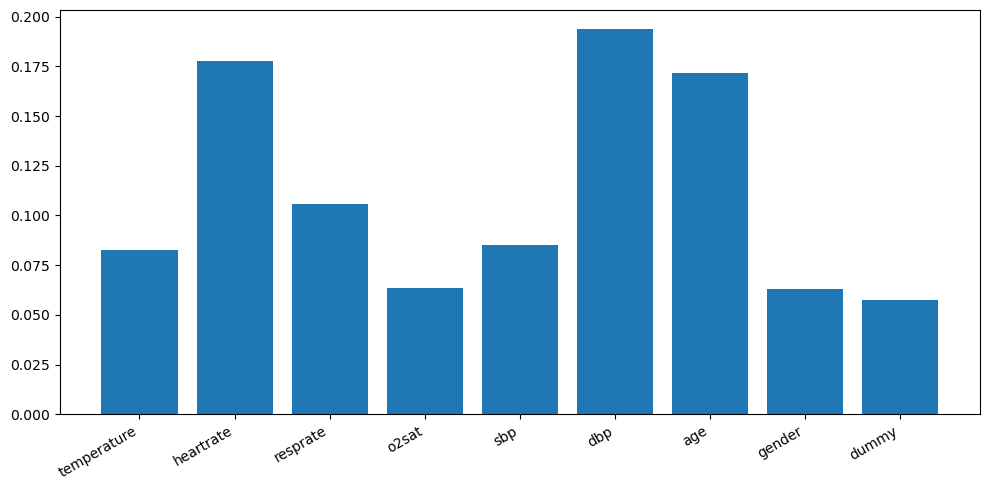

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.70903 |  0:00:00s
epoch 1  | loss: 1.5051  |  0:00:00s
epoch 2  | loss: 0.95234 |  0:00:00s
epoch 3  | loss: 0.65448 |  0:00:00s
epoch 4  | loss: 0.49318 |  0:00:00s
epoch 5  | loss: 0.5028  |  0:00:00s
epoch 6  | loss: 0.52574 |  0:00:00s
epoch 7  | loss: 0.44017 |  0:00:00s
epoch 8  | loss: 0.43582 |  0:00:00s
epoch 9  | loss: 0.3372  |  0:00:00s
epoch 10 | loss: 0.27668 |  0:00:00s
epoch 11 | loss: 0.2524  |  0:00:00s
epoch 12 | loss: 0.22197 |  0:00:00s
epoch 13 | loss: 0.18768 |  0:00:00s
epoch 14 | loss: 0.14094 |  0:00:00s
epoch 15 | loss: 0.11778 |  0:00:00s
epoch 16 | loss: 0.10831 |  0:00:00s
epoch 17 | loss: 0.07189 |  0:00:00s
epoch 18 | loss: 0.06154 |  0:00:00s
epoch 19 | loss: 0.05276 |  0:00:00s
epoch 20 | loss: 0.03824 |  0:00:00s
epoch 21 | loss: 0.06065 |  0:00:00s
epoch 22 | loss: 0.05507 |  0:00:00s
epoch 23 | loss: 0.02558 |  0:00:00s
epoch 24 | loss: 0.01599 |  0:00:00s
epoch 25 | loss: 0.01503 |  0:00:00s
epoch 26 | loss: 0.01268 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 16 | loss: 0.10831 |  0:00:00s
epoch 17 | loss: 0.07189 |  0:00:00s
epoch 18 | loss: 0.06154 |  0:00:00s
epoch 19 | loss: 0.05276 |  0:00:00s
epoch 20 | loss: 0.03824 |  0:00:00s
epoch 21 | loss: 0.06065 |  0:00:00s
epoch 22 | loss: 0.05507 |  0:00:00s
epoch 23 | loss: 0.02558 |  0:00:00s
epoch 24 | loss: 0.01599 |  0:00:00s
epoch 25 | loss: 0.01503 |  0:00:00s
epoch 26 | loss: 0.01268 |  0:00:00s
epoch 27 | loss: 0.01279 |  0:00:00s
epoch 28 | loss: 0.01253 |  0:00:00s
epoch 29 | loss: 0.01584 |  0:00:00s
epoch 30 | loss: 0.0122  |  0:00:00s
epoch 31 | loss: 0.00852 |  0:00:00s
epoch 32 | loss: 0.007   |  0:00:00s
epoch 33 | loss: 0.00969 |  0:00:00s
epoch 34 | loss: 0.00777 |  0:00:00s
epoch 35 | loss: 0.00812 |  0:00:00s
epoch 36 | loss: 0.02613 |  0:00:00s
epoch 37 | loss: 0.00567 |  0:00:00s
epoch 38 | loss: 0.00485 |  0:00:00s
epoch 39 | loss: 0.00733 |  0:00:00s
epoch 40 | loss: 0.1238  |  0:00:00s
epoch 41 | loss: 0.08138 |  0:00:00s
epoch 42 | loss: 0.03684 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 12 | loss: 0.22197 |  0:00:00s
epoch 13 | loss: 0.18768 |  0:00:00s
epoch 14 | loss: 0.14094 |  0:00:00s
epoch 15 | loss: 0.11778 |  0:00:00s
epoch 16 | loss: 0.10831 |  0:00:00s
epoch 17 | loss: 0.07189 |  0:00:00s
epoch 18 | loss: 0.06154 |  0:00:00s
epoch 19 | loss: 0.05276 |  0:00:00s
epoch 20 | loss: 0.03824 |  0:00:00s
epoch 21 | loss: 0.06065 |  0:00:00s
epoch 22 | loss: 0.05507 |  0:00:00s
epoch 23 | loss: 0.02558 |  0:00:00s
epoch 24 | loss: 0.01599 |  0:00:00s
epoch 25 | loss: 0.01503 |  0:00:00s
epoch 26 | loss: 0.01268 |  0:00:00s
epoch 27 | loss: 0.01279 |  0:00:00s
epoch 28 | loss: 0.01253 |  0:00:00s
epoch 29 | loss: 0.01584 |  0:00:00s
epoch 30 | loss: 0.0122  |  0:00:00s
epoch 31 | loss: 0.00852 |  0:00:00s
epoch 32 | loss: 0.007   |  0:00:00s
epoch 33 | loss: 0.00969 |  0:00:00s
epoch 34 | loss: 0.00777 |  0:00:00s
epoch 35 | loss: 0.00812 |  0:00:00s
epoch 36 | loss: 0.02613 |  0:00:00s
epoch 37 | loss: 0.00567 |  0:00:00s
epoch 38 | loss: 0.00485 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 3  | loss: 0.65448 |  0:00:00s
epoch 4  | loss: 0.49318 |  0:00:00s
epoch 5  | loss: 0.5028  |  0:00:00s
epoch 6  | loss: 0.52574 |  0:00:00s
epoch 7  | loss: 0.44017 |  0:00:00s
epoch 8  | loss: 0.43582 |  0:00:00s
epoch 9  | loss: 0.3372  |  0:00:00s
epoch 10 | loss: 0.27668 |  0:00:00s
epoch 11 | loss: 0.2524  |  0:00:00s
epoch 12 | loss: 0.22197 |  0:00:00s
epoch 13 | loss: 0.18768 |  0:00:00s
epoch 14 | loss: 0.14094 |  0:00:00s
epoch 15 | loss: 0.11778 |  0:00:00s
epoch 16 | loss: 0.10831 |  0:00:00s
epoch 17 | loss: 0.07189 |  0:00:00s
epoch 18 | loss: 0.06154 |  0:00:00s
epoch 19 | loss: 0.05276 |  0:00:00s
epoch 20 | loss: 0.03824 |  0:00:00s
epoch 21 | loss: 0.06065 |  0:00:00s
epoch 22 | loss: 0.05507 |  0:00:00s
epoch 23 | loss: 0.02558 |  0:00:00s
epoch 24 | loss: 0.01599 |  0:00:00s
epoch 25 | loss: 0.01503 |  0:00:00s
epoch 26 | loss: 0.01268 |  0:00:00s
epoch 27 | loss: 0.01279 |  0:00:00s
epoch 28 | loss: 0.01253 |  0:00:00s
epoch 29 | loss: 0.01584 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 6  | loss: 0.52574 |  0:00:00s
epoch 7  | loss: 0.44017 |  0:00:00s
epoch 8  | loss: 0.43582 |  0:00:00s
epoch 9  | loss: 0.3372  |  0:00:00s
epoch 10 | loss: 0.27668 |  0:00:00s
epoch 11 | loss: 0.2524  |  0:00:00s
epoch 12 | loss: 0.22197 |  0:00:00s
epoch 13 | loss: 0.18768 |  0:00:00s
epoch 14 | loss: 0.14094 |  0:00:00s
epoch 15 | loss: 0.11778 |  0:00:00s
epoch 16 | loss: 0.10831 |  0:00:00s
epoch 17 | loss: 0.07189 |  0:00:00s
epoch 18 | loss: 0.06154 |  0:00:00s
epoch 19 | loss: 0.05276 |  0:00:00s
epoch 20 | loss: 0.03824 |  0:00:00s
epoch 21 | loss: 0.06065 |  0:00:00s
epoch 22 | loss: 0.05507 |  0:00:00s
epoch 23 | loss: 0.02558 |  0:00:00s
epoch 24 | loss: 0.01599 |  0:00:00s
epoch 25 | loss: 0.01503 |  0:00:00s
epoch 26 | loss: 0.01268 |  0:00:00s
epoch 27 | loss: 0.01279 |  0:00:00s
epoch 28 | loss: 0.01253 |  0:00:00s
epoch 29 | loss: 0.01584 |  0:00:00s
epoch 30 | loss: 0.0122  |  0:00:00s
epoch 31 | loss: 0.00852 |  0:00:00s
epoch 32 | loss: 0.007   |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 7  | loss: 0.44017 |  0:00:00s
epoch 8  | loss: 0.43582 |  0:00:00s
epoch 9  | loss: 0.3372  |  0:00:00s
epoch 10 | loss: 0.27668 |  0:00:00s
epoch 11 | loss: 0.2524  |  0:00:00s
epoch 12 | loss: 0.22197 |  0:00:00s
epoch 13 | loss: 0.18768 |  0:00:00s
epoch 14 | loss: 0.14094 |  0:00:00s
epoch 15 | loss: 0.11778 |  0:00:00s
epoch 16 | loss: 0.10831 |  0:00:00s
epoch 17 | loss: 0.07189 |  0:00:00s
epoch 18 | loss: 0.06154 |  0:00:00s
epoch 19 | loss: 0.05276 |  0:00:00s
epoch 20 | loss: 0.03824 |  0:00:00s
epoch 21 | loss: 0.06065 |  0:00:00s
epoch 22 | loss: 0.05507 |  0:00:00s
epoch 23 | loss: 0.02558 |  0:00:00s
epoch 24 | loss: 0.01599 |  0:00:00s
epoch 25 | loss: 0.01503 |  0:00:00s
epoch 26 | loss: 0.01268 |  0:00:00s
epoch 27 | loss: 0.01279 |  0:00:00s
epoch 28 | loss: 0.01253 |  0:00:00s
epoch 29 | loss: 0.01584 |  0:00:00s
epoch 30 | loss: 0.0122  |  0:00:00s
epoch 31 | loss: 0.00852 |  0:00:00s
epoch 32 | loss: 0.007   |  0:00:00s
epoch 33 | loss: 0.00969 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 14 | loss: 0.14094 |  0:00:00s
epoch 15 | loss: 0.11778 |  0:00:00s
epoch 16 | loss: 0.10831 |  0:00:00s
epoch 17 | loss: 0.07189 |  0:00:00s
epoch 18 | loss: 0.06154 |  0:00:00s
epoch 19 | loss: 0.05276 |  0:00:00s
epoch 20 | loss: 0.03824 |  0:00:00s
epoch 21 | loss: 0.06065 |  0:00:00s
epoch 22 | loss: 0.05507 |  0:00:00s
epoch 23 | loss: 0.02558 |  0:00:00s
epoch 24 | loss: 0.01599 |  0:00:00s
epoch 25 | loss: 0.01503 |  0:00:00s
epoch 26 | loss: 0.01268 |  0:00:00s
epoch 27 | loss: 0.01279 |  0:00:00s
epoch 28 | loss: 0.01253 |  0:00:00s
epoch 29 | loss: 0.01584 |  0:00:00s
epoch 30 | loss: 0.0122  |  0:00:00s
epoch 31 | loss: 0.00852 |  0:00:00s
epoch 32 | loss: 0.007   |  0:00:00s
epoch 33 | loss: 0.00969 |  0:00:00s
epoch 34 | loss: 0.00777 |  0:00:00s
epoch 35 | loss: 0.00812 |  0:00:00s
epoch 36 | loss: 0.02613 |  0:00:00s
epoch 37 | loss: 0.00567 |  0:00:00s
epoch 38 | loss: 0.00485 |  0:00:00s
epoch 39 | loss: 0.00733 |  0:00:00s
epoch 40 | loss: 0.1238  |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 15 | loss: 0.11778 |  0:00:00s
epoch 16 | loss: 0.10831 |  0:00:00s
epoch 17 | loss: 0.07189 |  0:00:00s
epoch 18 | loss: 0.06154 |  0:00:00s
epoch 19 | loss: 0.05276 |  0:00:00s
epoch 20 | loss: 0.03824 |  0:00:00s
epoch 21 | loss: 0.06065 |  0:00:00s
epoch 22 | loss: 0.05507 |  0:00:00s
epoch 23 | loss: 0.02558 |  0:00:00s
epoch 24 | loss: 0.01599 |  0:00:00s
epoch 25 | loss: 0.01503 |  0:00:00s
epoch 26 | loss: 0.01268 |  0:00:00s
epoch 27 | loss: 0.01279 |  0:00:00s
epoch 28 | loss: 0.01253 |  0:00:00s
epoch 29 | loss: 0.01584 |  0:00:00s
epoch 30 | loss: 0.0122  |  0:00:00s
epoch 31 | loss: 0.00852 |  0:00:00s
epoch 32 | loss: 0.007   |  0:00:00s
epoch 33 | loss: 0.00969 |  0:00:00s
epoch 34 | loss: 0.00777 |  0:00:00s
epoch 35 | loss: 0.00812 |  0:00:00s
epoch 36 | loss: 0.02613 |  0:00:00s
epoch 37 | loss: 0.00567 |  0:00:00s
epoch 38 | loss: 0.00485 |  0:00:00s
epoch 39 | loss: 0.00733 |  0:00:00s
epoch 40 | loss: 0.1238  |  0:00:00s
epoch 41 | loss: 0.08138 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 2  | loss: 0.95234 |  0:00:00s
epoch 3  | loss: 0.65448 |  0:00:00s
epoch 4  | loss: 0.49318 |  0:00:00s
epoch 5  | loss: 0.5028  |  0:00:00s
epoch 6  | loss: 0.52574 |  0:00:00s
epoch 7  | loss: 0.44017 |  0:00:00s
epoch 8  | loss: 0.43582 |  0:00:00s
epoch 9  | loss: 0.3372  |  0:00:00s
epoch 10 | loss: 0.27668 |  0:00:00s
epoch 11 | loss: 0.2524  |  0:00:00s
epoch 12 | loss: 0.22197 |  0:00:00s
epoch 13 | loss: 0.18768 |  0:00:00s
epoch 14 | loss: 0.14094 |  0:00:00s
epoch 15 | loss: 0.11778 |  0:00:00s
epoch 16 | loss: 0.10831 |  0:00:00s
epoch 17 | loss: 0.07189 |  0:00:00s
epoch 18 | loss: 0.06154 |  0:00:00s
epoch 19 | loss: 0.05276 |  0:00:00s
epoch 20 | loss: 0.03824 |  0:00:00s
epoch 21 | loss: 0.06065 |  0:00:00s
epoch 22 | loss: 0.05507 |  0:00:00s
epoch 23 | loss: 0.02558 |  0:00:00s
epoch 24 | loss: 0.01599 |  0:00:00s
epoch 25 | loss: 0.01503 |  0:00:00s
epoch 26 | loss: 0.01268 |  0:00:00s
epoch 27 | loss: 0.01279 |  0:00:00s
epoch 28 | loss: 0.01253 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 6  | loss: 0.52574 |  0:00:00s
epoch 7  | loss: 0.44017 |  0:00:00s
epoch 8  | loss: 0.43582 |  0:00:00s
epoch 9  | loss: 0.3372  |  0:00:00s
epoch 10 | loss: 0.27668 |  0:00:00s
epoch 11 | loss: 0.2524  |  0:00:00s
epoch 12 | loss: 0.22197 |  0:00:00s
epoch 13 | loss: 0.18768 |  0:00:00s
epoch 14 | loss: 0.14094 |  0:00:00s
epoch 15 | loss: 0.11778 |  0:00:00s
epoch 16 | loss: 0.10831 |  0:00:00s
epoch 17 | loss: 0.07189 |  0:00:00s
epoch 18 | loss: 0.06154 |  0:00:00s
epoch 19 | loss: 0.05276 |  0:00:00s
epoch 20 | loss: 0.03824 |  0:00:00s
epoch 21 | loss: 0.06065 |  0:00:00s
epoch 22 | loss: 0.05507 |  0:00:00s
epoch 23 | loss: 0.02558 |  0:00:00s
epoch 24 | loss: 0.01599 |  0:00:00s
epoch 25 | loss: 0.01503 |  0:00:00s
epoch 26 | loss: 0.01268 |  0:00:00s
epoch 27 | loss: 0.01279 |  0:00:00s
epoch 28 | loss: 0.01253 |  0:00:00s
epoch 29 | loss: 0.01584 |  0:00:00s
epoch 30 | loss: 0.0122  |  0:00:00s
epoch 31 | loss: 0.00852 |  0:00:00s
epoch 32 | loss: 0.007   |  0:00:00s
e

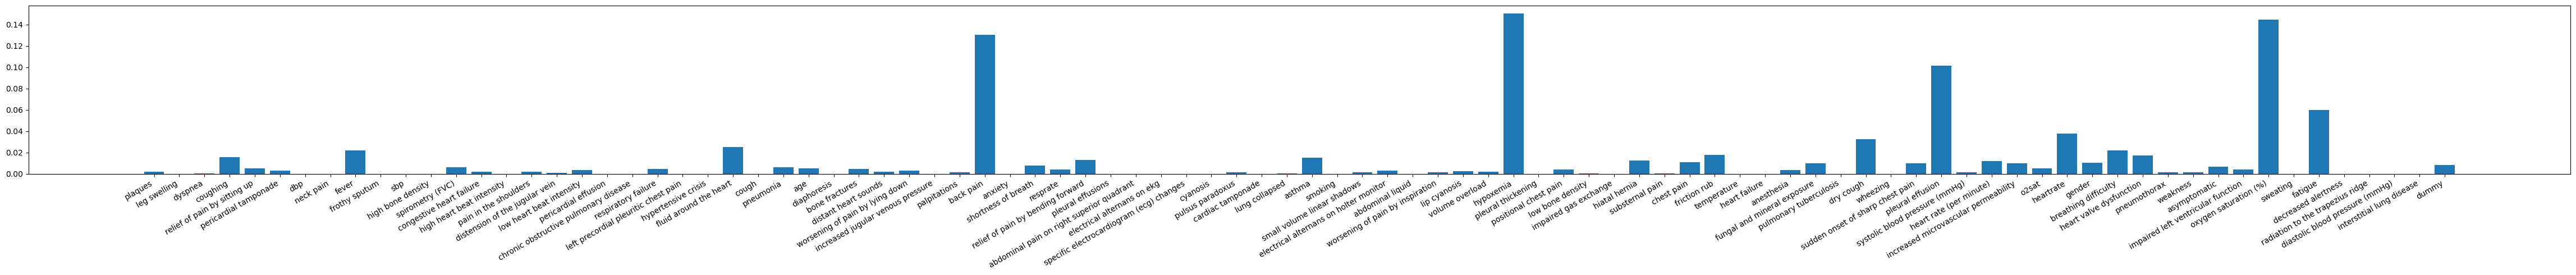

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.87261 |  0:00:00s
epoch 1  | loss: 1.33631 |  0:00:00s
epoch 2  | loss: 0.98721 |  0:00:00s
epoch 3  | loss: 0.74961 |  0:00:00s
epoch 4  | loss: 0.7132  |  0:00:00s
epoch 5  | loss: 0.66753 |  0:00:00s
epoch 6  | loss: 0.57426 |  0:00:00s
epoch 7  | loss: 0.53054 |  0:00:00s
epoch 8  | loss: 0.48405 |  0:00:00s
epoch 9  | loss: 0.49541 |  0:00:00s
epoch 10 | loss: 0.53999 |  0:00:00s
epoch 11 | loss: 0.48883 |  0:00:00s
epoch 12 | loss: 0.39184 |  0:00:00s
epoch 13 | loss: 0.40372 |  0:00:00s
epoch 14 | loss: 0.39517 |  0:00:00s
epoch 15 | loss: 0.40817 |  0:00:00s
epoch 16 | loss: 0.32627 |  0:00:00s
epoch 17 | loss: 0.33162 |  0:00:00s
epoch 18 | loss: 0.28064 |  0:00:00s
epoch 19 | loss: 0.30408 |  0:00:00s
epoch 20 | loss: 0.22953 |  0:00:00s
epoch 21 | loss: 0.2532  |  0:00:00s
epoch 22 | loss: 0.22412 |  0:00:00s
epoch 23 | loss: 0.21857 |  0:00:00s
epoch 24 | loss: 0.1754  |  0:00:00s
epoch 25 | loss: 0.15597 |  0:00:00s
epoch 26 | loss: 0.17491 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 11 | loss: 0.48883 |  0:00:00s
epoch 12 | loss: 0.39184 |  0:00:00s
epoch 13 | loss: 0.40372 |  0:00:00s
epoch 14 | loss: 0.39517 |  0:00:00s
epoch 15 | loss: 0.40817 |  0:00:00s
epoch 16 | loss: 0.32627 |  0:00:00s
epoch 17 | loss: 0.33162 |  0:00:00s
epoch 18 | loss: 0.28064 |  0:00:00s
epoch 19 | loss: 0.30408 |  0:00:00s
epoch 20 | loss: 0.22953 |  0:00:00s
epoch 21 | loss: 0.2532  |  0:00:00s
epoch 22 | loss: 0.22412 |  0:00:00s
epoch 23 | loss: 0.21857 |  0:00:00s
epoch 24 | loss: 0.1754  |  0:00:00s
epoch 25 | loss: 0.15597 |  0:00:00s
epoch 26 | loss: 0.17491 |  0:00:00s
epoch 27 | loss: 0.12664 |  0:00:00s
epoch 28 | loss: 0.11524 |  0:00:00s
epoch 29 | loss: 0.10599 |  0:00:00s
epoch 30 | loss: 0.1148  |  0:00:00s
epoch 31 | loss: 0.10215 |  0:00:00s
epoch 32 | loss: 0.0957  |  0:00:00s
epoch 33 | loss: 0.12624 |  0:00:00s
epoch 34 | loss: 0.09524 |  0:00:00s
epoch 35 | loss: 0.11997 |  0:00:00s
epoch 36 | loss: 0.06811 |  0:00:00s
epoch 37 | loss: 0.09108 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 2  | loss: 0.98721 |  0:00:00s
epoch 3  | loss: 0.74961 |  0:00:00s
epoch 4  | loss: 0.7132  |  0:00:00s
epoch 5  | loss: 0.66753 |  0:00:00s
epoch 6  | loss: 0.57426 |  0:00:00s
epoch 7  | loss: 0.53054 |  0:00:00s
epoch 8  | loss: 0.48405 |  0:00:00s
epoch 9  | loss: 0.49541 |  0:00:00s
epoch 10 | loss: 0.53999 |  0:00:00s
epoch 11 | loss: 0.48883 |  0:00:00s
epoch 12 | loss: 0.39184 |  0:00:00s
epoch 13 | loss: 0.40372 |  0:00:00s
epoch 14 | loss: 0.39517 |  0:00:00s
epoch 15 | loss: 0.40817 |  0:00:00s
epoch 16 | loss: 0.32627 |  0:00:00s
epoch 17 | loss: 0.33162 |  0:00:00s
epoch 18 | loss: 0.28064 |  0:00:00s
epoch 19 | loss: 0.30408 |  0:00:00s
epoch 20 | loss: 0.22953 |  0:00:00s
epoch 21 | loss: 0.2532  |  0:00:00s
epoch 22 | loss: 0.22412 |  0:00:00s
epoch 23 | loss: 0.21857 |  0:00:00s
epoch 24 | loss: 0.1754  |  0:00:00s
epoch 25 | loss: 0.15597 |  0:00:00s
epoch 26 | loss: 0.17491 |  0:00:00s
epoch 27 | loss: 0.12664 |  0:00:00s
epoch 28 | loss: 0.11524 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 9  | loss: 0.49541 |  0:00:00s
epoch 10 | loss: 0.53999 |  0:00:00s
epoch 11 | loss: 0.48883 |  0:00:00s
epoch 12 | loss: 0.39184 |  0:00:00s
epoch 13 | loss: 0.40372 |  0:00:00s
epoch 14 | loss: 0.39517 |  0:00:00s
epoch 15 | loss: 0.40817 |  0:00:00s
epoch 16 | loss: 0.32627 |  0:00:00s
epoch 17 | loss: 0.33162 |  0:00:00s
epoch 18 | loss: 0.28064 |  0:00:00s
epoch 19 | loss: 0.30408 |  0:00:00s
epoch 20 | loss: 0.22953 |  0:00:00s
epoch 21 | loss: 0.2532  |  0:00:00s
epoch 22 | loss: 0.22412 |  0:00:00s
epoch 23 | loss: 0.21857 |  0:00:00s
epoch 24 | loss: 0.1754  |  0:00:00s
epoch 25 | loss: 0.15597 |  0:00:00s
epoch 26 | loss: 0.17491 |  0:00:00s
epoch 27 | loss: 0.12664 |  0:00:00s
epoch 28 | loss: 0.11524 |  0:00:00s
epoch 29 | loss: 0.10599 |  0:00:00s
epoch 30 | loss: 0.1148  |  0:00:00s
epoch 31 | loss: 0.10215 |  0:00:00s
epoch 32 | loss: 0.0957  |  0:00:00s
epoch 33 | loss: 0.12624 |  0:00:00s
epoch 34 | loss: 0.09524 |  0:00:00s
epoch 35 | loss: 0.11997 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.87261 |  0:00:00s
epoch 1  | loss: 1.33631 |  0:00:00s
epoch 2  | loss: 0.98721 |  0:00:00s
epoch 3  | loss: 0.74961 |  0:00:00s
epoch 4  | loss: 0.7132  |  0:00:00s
epoch 5  | loss: 0.66753 |  0:00:00s
epoch 6  | loss: 0.57426 |  0:00:00s
epoch 7  | loss: 0.53054 |  0:00:00s
epoch 8  | loss: 0.48405 |  0:00:00s
epoch 9  | loss: 0.49541 |  0:00:00s
epoch 10 | loss: 0.53999 |  0:00:00s
epoch 11 | loss: 0.48883 |  0:00:00s
epoch 12 | loss: 0.39184 |  0:00:00s
epoch 13 | loss: 0.40372 |  0:00:00s
epoch 14 | loss: 0.39517 |  0:00:00s
epoch 15 | loss: 0.40817 |  0:00:00s
epoch 16 | loss: 0.32627 |  0:00:00s
epoch 17 | loss: 0.33162 |  0:00:00s
epoch 18 | loss: 0.28064 |  0:00:00s
epoch 19 | loss: 0.30408 |  0:00:00s
epoch 20 | loss: 0.22953 |  0:00:00s
epoch 21 | loss: 0.2532  |  0:00:00s
epoch 22 | loss: 0.22412 |  0:00:00s
epoch 23 | loss: 0.21857 |  0:00:00s
epoch 24 | loss: 0.1754  |  0:00:00s
epoch 25 | loss: 0.15597 |  0:00:00s
epoch 26 | loss: 0.17491 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 8  | loss: 0.48405 |  0:00:00s
epoch 9  | loss: 0.49541 |  0:00:00s
epoch 10 | loss: 0.53999 |  0:00:00s
epoch 11 | loss: 0.48883 |  0:00:00s
epoch 12 | loss: 0.39184 |  0:00:00s
epoch 13 | loss: 0.40372 |  0:00:00s
epoch 14 | loss: 0.39517 |  0:00:00s
epoch 15 | loss: 0.40817 |  0:00:00s
epoch 16 | loss: 0.32627 |  0:00:00s
epoch 17 | loss: 0.33162 |  0:00:00s
epoch 18 | loss: 0.28064 |  0:00:00s
epoch 19 | loss: 0.30408 |  0:00:00s
epoch 20 | loss: 0.22953 |  0:00:00s
epoch 21 | loss: 0.2532  |  0:00:00s
epoch 22 | loss: 0.22412 |  0:00:00s
epoch 23 | loss: 0.21857 |  0:00:00s
epoch 24 | loss: 0.1754  |  0:00:00s
epoch 25 | loss: 0.15597 |  0:00:00s
epoch 26 | loss: 0.17491 |  0:00:00s
epoch 27 | loss: 0.12664 |  0:00:00s
epoch 28 | loss: 0.11524 |  0:00:00s
epoch 29 | loss: 0.10599 |  0:00:00s
epoch 30 | loss: 0.1148  |  0:00:00s
epoch 31 | loss: 0.10215 |  0:00:00s
epoch 32 | loss: 0.0957  |  0:00:00s
epoch 33 | loss: 0.12624 |  0:00:00s
epoch 34 | loss: 0.09524 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 12 | loss: 0.39184 |  0:00:00s
epoch 13 | loss: 0.40372 |  0:00:00s
epoch 14 | loss: 0.39517 |  0:00:00s
epoch 15 | loss: 0.40817 |  0:00:00s
epoch 16 | loss: 0.32627 |  0:00:00s
epoch 17 | loss: 0.33162 |  0:00:00s
epoch 18 | loss: 0.28064 |  0:00:00s
epoch 19 | loss: 0.30408 |  0:00:00s
epoch 20 | loss: 0.22953 |  0:00:00s
epoch 21 | loss: 0.2532  |  0:00:00s
epoch 22 | loss: 0.22412 |  0:00:00s
epoch 23 | loss: 0.21857 |  0:00:00s
epoch 24 | loss: 0.1754  |  0:00:00s
epoch 25 | loss: 0.15597 |  0:00:00s
epoch 26 | loss: 0.17491 |  0:00:00s
epoch 27 | loss: 0.12664 |  0:00:00s
epoch 28 | loss: 0.11524 |  0:00:00s
epoch 29 | loss: 0.10599 |  0:00:00s
epoch 30 | loss: 0.1148  |  0:00:00s
epoch 31 | loss: 0.10215 |  0:00:00s
epoch 32 | loss: 0.0957  |  0:00:00s
epoch 33 | loss: 0.12624 |  0:00:00s
epoch 34 | loss: 0.09524 |  0:00:00s
epoch 35 | loss: 0.11997 |  0:00:00s
epoch 36 | loss: 0.06811 |  0:00:00s
epoch 37 | loss: 0.09108 |  0:00:00s
epoch 38 | loss: 0.05675 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 9  | loss: 0.49541 |  0:00:00s
epoch 10 | loss: 0.53999 |  0:00:00s
epoch 11 | loss: 0.48883 |  0:00:00s
epoch 12 | loss: 0.39184 |  0:00:00s
epoch 13 | loss: 0.40372 |  0:00:00s
epoch 14 | loss: 0.39517 |  0:00:00s
epoch 15 | loss: 0.40817 |  0:00:00s
epoch 16 | loss: 0.32627 |  0:00:00s
epoch 17 | loss: 0.33162 |  0:00:00s
epoch 18 | loss: 0.28064 |  0:00:00s
epoch 19 | loss: 0.30408 |  0:00:00s
epoch 20 | loss: 0.22953 |  0:00:00s
epoch 21 | loss: 0.2532  |  0:00:00s
epoch 22 | loss: 0.22412 |  0:00:00s
epoch 23 | loss: 0.21857 |  0:00:00s
epoch 24 | loss: 0.1754  |  0:00:00s
epoch 25 | loss: 0.15597 |  0:00:00s
epoch 26 | loss: 0.17491 |  0:00:00s
epoch 27 | loss: 0.12664 |  0:00:00s
epoch 28 | loss: 0.11524 |  0:00:00s
epoch 29 | loss: 0.10599 |  0:00:00s
epoch 30 | loss: 0.1148  |  0:00:00s
epoch 31 | loss: 0.10215 |  0:00:00s
epoch 32 | loss: 0.0957  |  0:00:00s
epoch 33 | loss: 0.12624 |  0:00:00s
epoch 34 | loss: 0.09524 |  0:00:00s
epoch 35 | loss: 0.11997 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 11 | loss: 0.48883 |  0:00:00s
epoch 12 | loss: 0.39184 |  0:00:00s
epoch 13 | loss: 0.40372 |  0:00:00s
epoch 14 | loss: 0.39517 |  0:00:00s
epoch 15 | loss: 0.40817 |  0:00:00s
epoch 16 | loss: 0.32627 |  0:00:00s
epoch 17 | loss: 0.33162 |  0:00:00s
epoch 18 | loss: 0.28064 |  0:00:00s
epoch 19 | loss: 0.30408 |  0:00:00s
epoch 20 | loss: 0.22953 |  0:00:00s
epoch 21 | loss: 0.2532  |  0:00:00s
epoch 22 | loss: 0.22412 |  0:00:00s
epoch 23 | loss: 0.21857 |  0:00:00s
epoch 24 | loss: 0.1754  |  0:00:00s
epoch 25 | loss: 0.15597 |  0:00:00s
epoch 26 | loss: 0.17491 |  0:00:00s
epoch 27 | loss: 0.12664 |  0:00:00s
epoch 28 | loss: 0.11524 |  0:00:00s
epoch 29 | loss: 0.10599 |  0:00:00s
epoch 30 | loss: 0.1148  |  0:00:00s
epoch 31 | loss: 0.10215 |  0:00:00s
epoch 32 | loss: 0.0957  |  0:00:00s
epoch 33 | loss: 0.12624 |  0:00:00s
epoch 34 | loss: 0.09524 |  0:00:00s
epoch 35 | loss: 0.11997 |  0:00:00s
epoch 36 | loss: 0.06811 |  0:00:00s
epoch 37 | loss: 0.09108 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 13 | loss: 0.40372 |  0:00:00s
epoch 14 | loss: 0.39517 |  0:00:00s
epoch 15 | loss: 0.40817 |  0:00:00s
epoch 16 | loss: 0.32627 |  0:00:00s
epoch 17 | loss: 0.33162 |  0:00:00s
epoch 18 | loss: 0.28064 |  0:00:00s
epoch 19 | loss: 0.30408 |  0:00:00s
epoch 20 | loss: 0.22953 |  0:00:00s
epoch 21 | loss: 0.2532  |  0:00:00s
epoch 22 | loss: 0.22412 |  0:00:00s
epoch 23 | loss: 0.21857 |  0:00:00s
epoch 24 | loss: 0.1754  |  0:00:00s
epoch 25 | loss: 0.15597 |  0:00:00s
epoch 26 | loss: 0.17491 |  0:00:00s
epoch 27 | loss: 0.12664 |  0:00:00s
epoch 28 | loss: 0.11524 |  0:00:00s
epoch 29 | loss: 0.10599 |  0:00:00s
epoch 30 | loss: 0.1148  |  0:00:00s
epoch 31 | loss: 0.10215 |  0:00:00s
epoch 32 | loss: 0.0957  |  0:00:00s
epoch 33 | loss: 0.12624 |  0:00:00s
epoch 34 | loss: 0.09524 |  0:00:00s
epoch 35 | loss: 0.11997 |  0:00:00s
epoch 36 | loss: 0.06811 |  0:00:00s
epoch 37 | loss: 0.09108 |  0:00:00s
epoch 38 | loss: 0.05675 |  0:00:00s
epoch 39 | loss: 0.07005 |  0:00:00s
e

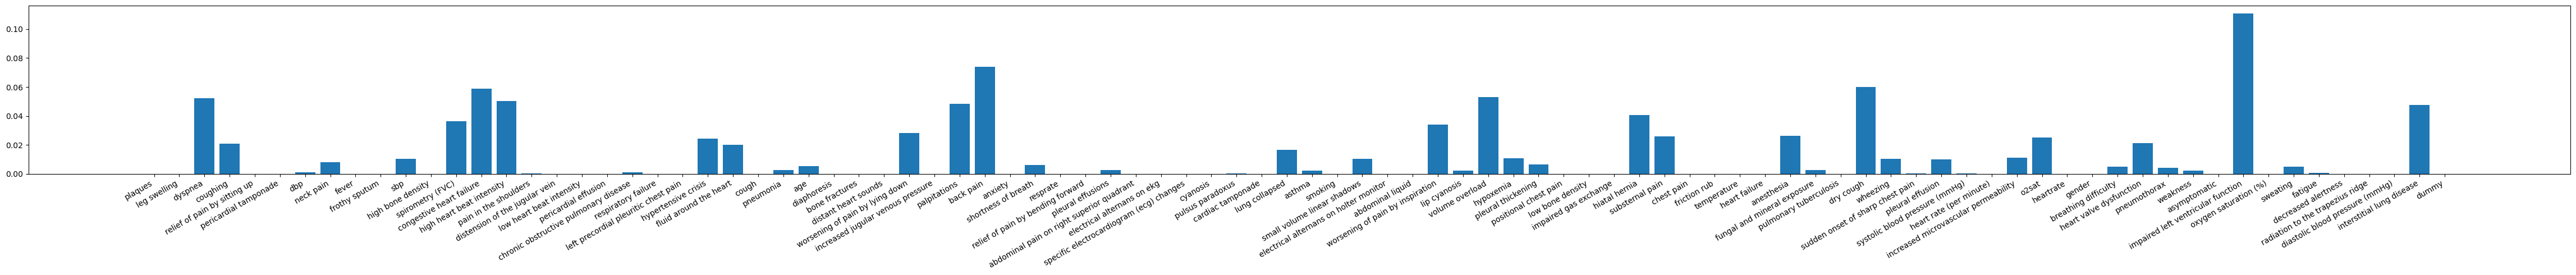

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.80568 |  0:00:00s
epoch 1  | loss: 1.4992  |  0:00:00s
epoch 2  | loss: 1.13481 |  0:00:00s
epoch 3  | loss: 0.87328 |  0:00:00s
epoch 4  | loss: 0.78525 |  0:00:00s
epoch 5  | loss: 0.65467 |  0:00:00s
epoch 6  | loss: 0.61771 |  0:00:00s
epoch 7  | loss: 0.63311 |  0:00:00s
epoch 8  | loss: 0.55967 |  0:00:00s
epoch 9  | loss: 0.66674 |  0:00:00s
epoch 10 | loss: 0.60266 |  0:00:00s
epoch 11 | loss: 0.54964 |  0:00:00s
epoch 12 | loss: 0.49132 |  0:00:00s
epoch 13 | loss: 0.4586  |  0:00:00s
epoch 14 | loss: 0.48105 |  0:00:00s
epoch 15 | loss: 0.40451 |  0:00:00s
epoch 16 | loss: 0.3694  |  0:00:00s
epoch 17 | loss: 0.42158 |  0:00:00s
epoch 18 | loss: 0.37699 |  0:00:00s
epoch 19 | loss: 0.38782 |  0:00:00s
epoch 20 | loss: 0.34169 |  0:00:00s
epoch 21 | loss: 0.29645 |  0:00:00s
epoch 22 | loss: 0.32033 |  0:00:00s
epoch 23 | loss: 0.30388 |  0:00:00s
epoch 24 | loss: 0.2955  |  0:00:00s
epoch 25 | loss: 0.30733 |  0:00:00s
epoch 26 | loss: 0.26744 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.80568 |  0:00:00s
epoch 1  | loss: 1.4992  |  0:00:00s
epoch 2  | loss: 1.13481 |  0:00:00s
epoch 3  | loss: 0.87328 |  0:00:00s
epoch 4  | loss: 0.78525 |  0:00:00s
epoch 5  | loss: 0.65467 |  0:00:00s
epoch 6  | loss: 0.61771 |  0:00:00s
epoch 7  | loss: 0.63311 |  0:00:00s
epoch 8  | loss: 0.55967 |  0:00:00s
epoch 9  | loss: 0.66674 |  0:00:00s
epoch 10 | loss: 0.60266 |  0:00:00s
epoch 11 | loss: 0.54964 |  0:00:00s
epoch 12 | loss: 0.49132 |  0:00:00s
epoch 13 | loss: 0.4586  |  0:00:00s
epoch 14 | loss: 0.48105 |  0:00:00s
epoch 15 | loss: 0.40451 |  0:00:00s
epoch 16 | loss: 0.3694  |  0:00:00s
epoch 17 | loss: 0.42158 |  0:00:00s
epoch 18 | loss: 0.37699 |  0:00:00s
epoch 19 | loss: 0.38782 |  0:00:00s
epoch 20 | loss: 0.34169 |  0:00:00s
epoch 21 | loss: 0.29645 |  0:00:00s
epoch 22 | loss: 0.32033 |  0:00:00s
epoch 23 | loss: 0.30388 |  0:00:00s
epoch 24 | loss: 0.2955  |  0:00:00s
epoch 25 | loss: 0.30733 |  0:00:00s
epoch 26 | loss: 0.26744 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 6  | loss: 0.61771 |  0:00:00s
epoch 7  | loss: 0.63311 |  0:00:00s
epoch 8  | loss: 0.55967 |  0:00:00s
epoch 9  | loss: 0.66674 |  0:00:00s
epoch 10 | loss: 0.60266 |  0:00:00s
epoch 11 | loss: 0.54964 |  0:00:00s
epoch 12 | loss: 0.49132 |  0:00:00s
epoch 13 | loss: 0.4586  |  0:00:00s
epoch 14 | loss: 0.48105 |  0:00:00s
epoch 15 | loss: 0.40451 |  0:00:00s
epoch 16 | loss: 0.3694  |  0:00:00s
epoch 17 | loss: 0.42158 |  0:00:00s
epoch 18 | loss: 0.37699 |  0:00:00s
epoch 19 | loss: 0.38782 |  0:00:00s
epoch 20 | loss: 0.34169 |  0:00:00s
epoch 21 | loss: 0.29645 |  0:00:00s
epoch 22 | loss: 0.32033 |  0:00:00s
epoch 23 | loss: 0.30388 |  0:00:00s
epoch 24 | loss: 0.2955  |  0:00:00s
epoch 25 | loss: 0.30733 |  0:00:00s
epoch 26 | loss: 0.26744 |  0:00:00s
epoch 27 | loss: 0.23285 |  0:00:00s
epoch 28 | loss: 0.23614 |  0:00:00s
epoch 29 | loss: 0.19373 |  0:00:00s
epoch 30 | loss: 0.1425  |  0:00:00s
epoch 31 | loss: 0.21605 |  0:00:00s
epoch 32 | loss: 0.23668 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 12 | loss: 0.49132 |  0:00:00s
epoch 13 | loss: 0.4586  |  0:00:00s
epoch 14 | loss: 0.48105 |  0:00:00s
epoch 15 | loss: 0.40451 |  0:00:00s
epoch 16 | loss: 0.3694  |  0:00:00s
epoch 17 | loss: 0.42158 |  0:00:00s
epoch 18 | loss: 0.37699 |  0:00:00s
epoch 19 | loss: 0.38782 |  0:00:00s
epoch 20 | loss: 0.34169 |  0:00:00s
epoch 21 | loss: 0.29645 |  0:00:00s
epoch 22 | loss: 0.32033 |  0:00:00s
epoch 23 | loss: 0.30388 |  0:00:00s
epoch 24 | loss: 0.2955  |  0:00:00s
epoch 25 | loss: 0.30733 |  0:00:00s
epoch 26 | loss: 0.26744 |  0:00:00s
epoch 27 | loss: 0.23285 |  0:00:00s
epoch 28 | loss: 0.23614 |  0:00:00s
epoch 29 | loss: 0.19373 |  0:00:00s
epoch 30 | loss: 0.1425  |  0:00:00s
epoch 31 | loss: 0.21605 |  0:00:00s
epoch 32 | loss: 0.23668 |  0:00:00s
epoch 33 | loss: 0.13898 |  0:00:00s
epoch 34 | loss: 0.10964 |  0:00:00s
epoch 35 | loss: 0.12504 |  0:00:00s
epoch 36 | loss: 0.16833 |  0:00:00s
epoch 37 | loss: 0.12934 |  0:00:00s
epoch 38 | loss: 0.1314  |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 8  | loss: 0.55967 |  0:00:00s
epoch 9  | loss: 0.66674 |  0:00:00s
epoch 10 | loss: 0.60266 |  0:00:00s
epoch 11 | loss: 0.54964 |  0:00:00s
epoch 12 | loss: 0.49132 |  0:00:00s
epoch 13 | loss: 0.4586  |  0:00:00s
epoch 14 | loss: 0.48105 |  0:00:00s
epoch 15 | loss: 0.40451 |  0:00:00s
epoch 16 | loss: 0.3694  |  0:00:00s
epoch 17 | loss: 0.42158 |  0:00:00s
epoch 18 | loss: 0.37699 |  0:00:00s
epoch 19 | loss: 0.38782 |  0:00:00s
epoch 20 | loss: 0.34169 |  0:00:00s
epoch 21 | loss: 0.29645 |  0:00:00s
epoch 22 | loss: 0.32033 |  0:00:00s
epoch 23 | loss: 0.30388 |  0:00:00s
epoch 24 | loss: 0.2955  |  0:00:00s
epoch 25 | loss: 0.30733 |  0:00:00s
epoch 26 | loss: 0.26744 |  0:00:00s
epoch 27 | loss: 0.23285 |  0:00:00s
epoch 28 | loss: 0.23614 |  0:00:00s
epoch 29 | loss: 0.19373 |  0:00:00s
epoch 30 | loss: 0.1425  |  0:00:00s
epoch 31 | loss: 0.21605 |  0:00:00s
epoch 32 | loss: 0.23668 |  0:00:00s
epoch 33 | loss: 0.13898 |  0:00:00s
epoch 34 | loss: 0.10964 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 9  | loss: 0.66674 |  0:00:00s
epoch 10 | loss: 0.60266 |  0:00:00s
epoch 11 | loss: 0.54964 |  0:00:00s
epoch 12 | loss: 0.49132 |  0:00:00s
epoch 13 | loss: 0.4586  |  0:00:00s
epoch 14 | loss: 0.48105 |  0:00:00s
epoch 15 | loss: 0.40451 |  0:00:00s
epoch 16 | loss: 0.3694  |  0:00:00s
epoch 17 | loss: 0.42158 |  0:00:00s
epoch 18 | loss: 0.37699 |  0:00:00s
epoch 19 | loss: 0.38782 |  0:00:00s
epoch 20 | loss: 0.34169 |  0:00:00s
epoch 21 | loss: 0.29645 |  0:00:00s
epoch 22 | loss: 0.32033 |  0:00:00s
epoch 23 | loss: 0.30388 |  0:00:00s
epoch 24 | loss: 0.2955  |  0:00:00s
epoch 25 | loss: 0.30733 |  0:00:00s
epoch 26 | loss: 0.26744 |  0:00:00s
epoch 27 | loss: 0.23285 |  0:00:00s
epoch 28 | loss: 0.23614 |  0:00:00s
epoch 29 | loss: 0.19373 |  0:00:00s
epoch 30 | loss: 0.1425  |  0:00:00s
epoch 31 | loss: 0.21605 |  0:00:00s
epoch 32 | loss: 0.23668 |  0:00:00s
epoch 33 | loss: 0.13898 |  0:00:00s
epoch 34 | loss: 0.10964 |  0:00:00s
epoch 35 | loss: 0.12504 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 8  | loss: 0.55967 |  0:00:00s
epoch 9  | loss: 0.66674 |  0:00:00s
epoch 10 | loss: 0.60266 |  0:00:00s
epoch 11 | loss: 0.54964 |  0:00:00s
epoch 12 | loss: 0.49132 |  0:00:00s
epoch 13 | loss: 0.4586  |  0:00:00s
epoch 14 | loss: 0.48105 |  0:00:00s
epoch 15 | loss: 0.40451 |  0:00:00s
epoch 16 | loss: 0.3694  |  0:00:00s
epoch 17 | loss: 0.42158 |  0:00:00s
epoch 18 | loss: 0.37699 |  0:00:00s
epoch 19 | loss: 0.38782 |  0:00:00s
epoch 20 | loss: 0.34169 |  0:00:00s
epoch 21 | loss: 0.29645 |  0:00:00s
epoch 22 | loss: 0.32033 |  0:00:00s
epoch 23 | loss: 0.30388 |  0:00:00s
epoch 24 | loss: 0.2955  |  0:00:00s
epoch 25 | loss: 0.30733 |  0:00:00s
epoch 26 | loss: 0.26744 |  0:00:00s
epoch 27 | loss: 0.23285 |  0:00:00s
epoch 28 | loss: 0.23614 |  0:00:00s
epoch 29 | loss: 0.19373 |  0:00:00s
epoch 30 | loss: 0.1425  |  0:00:00s
epoch 31 | loss: 0.21605 |  0:00:00s
epoch 32 | loss: 0.23668 |  0:00:00s
epoch 33 | loss: 0.13898 |  0:00:00s
epoch 34 | loss: 0.10964 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 4  | loss: 0.78525 |  0:00:00s
epoch 5  | loss: 0.65467 |  0:00:00s
epoch 6  | loss: 0.61771 |  0:00:00s
epoch 7  | loss: 0.63311 |  0:00:00s
epoch 8  | loss: 0.55967 |  0:00:00s
epoch 9  | loss: 0.66674 |  0:00:00s
epoch 10 | loss: 0.60266 |  0:00:00s
epoch 11 | loss: 0.54964 |  0:00:00s
epoch 12 | loss: 0.49132 |  0:00:00s
epoch 13 | loss: 0.4586  |  0:00:00s
epoch 14 | loss: 0.48105 |  0:00:00s
epoch 15 | loss: 0.40451 |  0:00:00s
epoch 16 | loss: 0.3694  |  0:00:00s
epoch 17 | loss: 0.42158 |  0:00:00s
epoch 18 | loss: 0.37699 |  0:00:00s
epoch 19 | loss: 0.38782 |  0:00:00s
epoch 20 | loss: 0.34169 |  0:00:00s
epoch 21 | loss: 0.29645 |  0:00:00s
epoch 22 | loss: 0.32033 |  0:00:00s
epoch 23 | loss: 0.30388 |  0:00:00s
epoch 24 | loss: 0.2955  |  0:00:00s
epoch 25 | loss: 0.30733 |  0:00:00s
epoch 26 | loss: 0.26744 |  0:00:00s
epoch 27 | loss: 0.23285 |  0:00:00s
epoch 28 | loss: 0.23614 |  0:00:00s
epoch 29 | loss: 0.19373 |  0:00:00s
epoch 30 | loss: 0.1425  |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.80568 |  0:00:00s
epoch 1  | loss: 1.4992  |  0:00:00s
epoch 2  | loss: 1.13481 |  0:00:00s
epoch 3  | loss: 0.87328 |  0:00:00s
epoch 4  | loss: 0.78525 |  0:00:00s
epoch 5  | loss: 0.65467 |  0:00:00s
epoch 6  | loss: 0.61771 |  0:00:00s
epoch 7  | loss: 0.63311 |  0:00:00s
epoch 8  | loss: 0.55967 |  0:00:00s
epoch 9  | loss: 0.66674 |  0:00:00s
epoch 10 | loss: 0.60266 |  0:00:00s
epoch 11 | loss: 0.54964 |  0:00:00s
epoch 12 | loss: 0.49132 |  0:00:00s
epoch 13 | loss: 0.4586  |  0:00:00s
epoch 14 | loss: 0.48105 |  0:00:00s
epoch 15 | loss: 0.40451 |  0:00:00s
epoch 16 | loss: 0.3694  |  0:00:00s
epoch 17 | loss: 0.42158 |  0:00:00s
epoch 18 | loss: 0.37699 |  0:00:00s
epoch 19 | loss: 0.38782 |  0:00:00s
epoch 20 | loss: 0.34169 |  0:00:00s
epoch 21 | loss: 0.29645 |  0:00:00s
epoch 22 | loss: 0.32033 |  0:00:00s
epoch 23 | loss: 0.30388 |  0:00:00s
epoch 24 | loss: 0.2955  |  0:00:00s
epoch 25 | loss: 0.30733 |  0:00:00s
epoch 26 | loss: 0.26744 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 9  | loss: 0.66674 |  0:00:00s
epoch 10 | loss: 0.60266 |  0:00:00s
epoch 11 | loss: 0.54964 |  0:00:00s
epoch 12 | loss: 0.49132 |  0:00:00s
epoch 13 | loss: 0.4586  |  0:00:00s
epoch 14 | loss: 0.48105 |  0:00:00s
epoch 15 | loss: 0.40451 |  0:00:00s
epoch 16 | loss: 0.3694  |  0:00:00s
epoch 17 | loss: 0.42158 |  0:00:00s
epoch 18 | loss: 0.37699 |  0:00:00s
epoch 19 | loss: 0.38782 |  0:00:00s
epoch 20 | loss: 0.34169 |  0:00:00s
epoch 21 | loss: 0.29645 |  0:00:00s
epoch 22 | loss: 0.32033 |  0:00:00s
epoch 23 | loss: 0.30388 |  0:00:00s
epoch 24 | loss: 0.2955  |  0:00:00s
epoch 25 | loss: 0.30733 |  0:00:00s
epoch 26 | loss: 0.26744 |  0:00:00s
epoch 27 | loss: 0.23285 |  0:00:00s
epoch 28 | loss: 0.23614 |  0:00:00s
epoch 29 | loss: 0.19373 |  0:00:00s
epoch 30 | loss: 0.1425  |  0:00:00s
epoch 31 | loss: 0.21605 |  0:00:00s
epoch 32 | loss: 0.23668 |  0:00:00s
epoch 33 | loss: 0.13898 |  0:00:00s
epoch 34 | loss: 0.10964 |  0:00:00s
epoch 35 | loss: 0.12504 |  0:00:00s
e

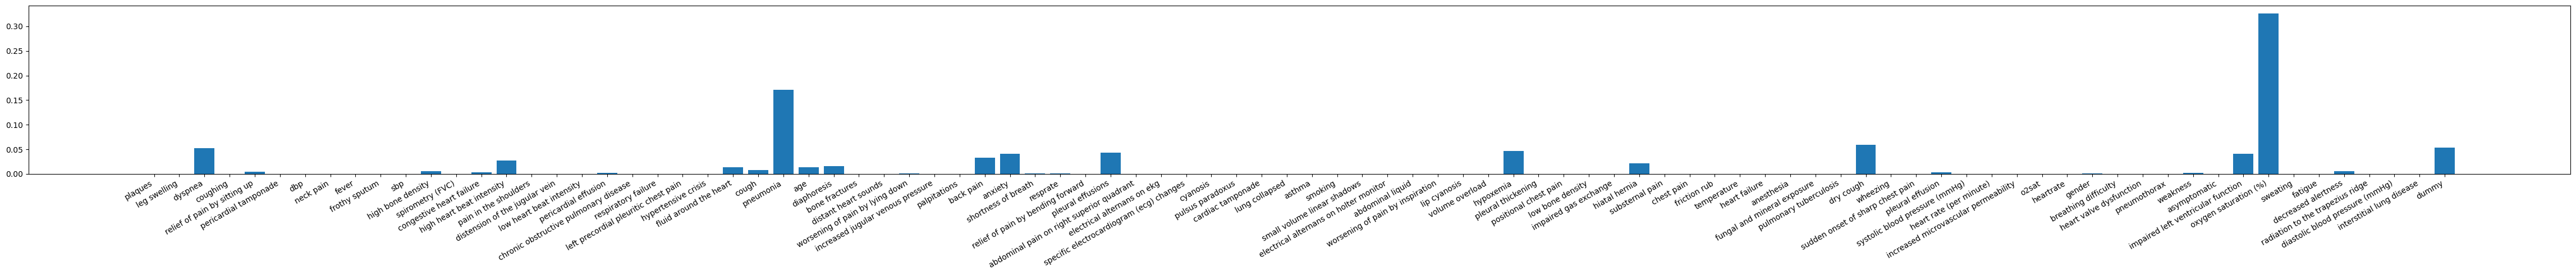

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.84191 |  0:00:00s
epoch 1  | loss: 1.34409 |  0:00:00s
epoch 2  | loss: 1.11949 |  0:00:00s
epoch 3  | loss: 0.90618 |  0:00:00s
epoch 4  | loss: 0.72707 |  0:00:00s
epoch 5  | loss: 0.80334 |  0:00:00s
epoch 6  | loss: 0.62682 |  0:00:00s
epoch 7  | loss: 0.60683 |  0:00:00s
epoch 8  | loss: 0.53467 |  0:00:00s
epoch 9  | loss: 0.52548 |  0:00:00s
epoch 10 | loss: 0.56671 |  0:00:00s
epoch 11 | loss: 0.48255 |  0:00:00s
epoch 12 | loss: 0.52056 |  0:00:00s
epoch 13 | loss: 0.43768 |  0:00:00s
epoch 14 | loss: 0.45265 |  0:00:00s
epoch 15 | loss: 0.38279 |  0:00:00s
epoch 16 | loss: 0.38591 |  0:00:00s
epoch 17 | loss: 0.37257 |  0:00:00s
epoch 18 | loss: 0.39695 |  0:00:00s
epoch 19 | loss: 0.34201 |  0:00:00s
epoch 20 | loss: 0.32536 |  0:00:00s
epoch 21 | loss: 0.32752 |  0:00:00s
epoch 22 | loss: 0.32722 |  0:00:00s
epoch 23 | loss: 0.36822 |  0:00:00s
epoch 24 | loss: 0.29854 |  0:00:00s
epoch 25 | loss: 0.31212 |  0:00:00s
epoch 26 | loss: 0.35167 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 8  | loss: 0.53467 |  0:00:00s
epoch 9  | loss: 0.52548 |  0:00:00s
epoch 10 | loss: 0.56671 |  0:00:00s
epoch 11 | loss: 0.48255 |  0:00:00s
epoch 12 | loss: 0.52056 |  0:00:00s
epoch 13 | loss: 0.43768 |  0:00:00s
epoch 14 | loss: 0.45265 |  0:00:00s
epoch 15 | loss: 0.38279 |  0:00:00s
epoch 16 | loss: 0.38591 |  0:00:00s
epoch 17 | loss: 0.37257 |  0:00:00s
epoch 18 | loss: 0.39695 |  0:00:00s
epoch 19 | loss: 0.34201 |  0:00:00s
epoch 20 | loss: 0.32536 |  0:00:00s
epoch 21 | loss: 0.32752 |  0:00:00s
epoch 22 | loss: 0.32722 |  0:00:00s
epoch 23 | loss: 0.36822 |  0:00:00s
epoch 24 | loss: 0.29854 |  0:00:00s
epoch 25 | loss: 0.31212 |  0:00:00s
epoch 26 | loss: 0.35167 |  0:00:00s
epoch 27 | loss: 0.31018 |  0:00:00s
epoch 28 | loss: 0.2656  |  0:00:00s
epoch 29 | loss: 0.29899 |  0:00:00s
epoch 30 | loss: 0.25971 |  0:00:00s
epoch 31 | loss: 0.21479 |  0:00:00s
epoch 32 | loss: 0.21249 |  0:00:00s
epoch 33 | loss: 0.21701 |  0:00:00s
epoch 34 | loss: 0.20096 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 7  | loss: 0.60683 |  0:00:00s
epoch 8  | loss: 0.53467 |  0:00:00s
epoch 9  | loss: 0.52548 |  0:00:00s
epoch 10 | loss: 0.56671 |  0:00:00s
epoch 11 | loss: 0.48255 |  0:00:00s
epoch 12 | loss: 0.52056 |  0:00:00s
epoch 13 | loss: 0.43768 |  0:00:00s
epoch 14 | loss: 0.45265 |  0:00:00s
epoch 15 | loss: 0.38279 |  0:00:00s
epoch 16 | loss: 0.38591 |  0:00:00s
epoch 17 | loss: 0.37257 |  0:00:00s
epoch 18 | loss: 0.39695 |  0:00:00s
epoch 19 | loss: 0.34201 |  0:00:00s
epoch 20 | loss: 0.32536 |  0:00:00s
epoch 21 | loss: 0.32752 |  0:00:00s
epoch 22 | loss: 0.32722 |  0:00:00s
epoch 23 | loss: 0.36822 |  0:00:00s
epoch 24 | loss: 0.29854 |  0:00:00s
epoch 25 | loss: 0.31212 |  0:00:00s
epoch 26 | loss: 0.35167 |  0:00:00s
epoch 27 | loss: 0.31018 |  0:00:00s
epoch 28 | loss: 0.2656  |  0:00:00s
epoch 29 | loss: 0.29899 |  0:00:00s
epoch 30 | loss: 0.25971 |  0:00:00s
epoch 31 | loss: 0.21479 |  0:00:00s
epoch 32 | loss: 0.21249 |  0:00:00s
epoch 33 | loss: 0.21701 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 9  | loss: 0.52548 |  0:00:00s
epoch 10 | loss: 0.56671 |  0:00:00s
epoch 11 | loss: 0.48255 |  0:00:00s
epoch 12 | loss: 0.52056 |  0:00:00s
epoch 13 | loss: 0.43768 |  0:00:00s
epoch 14 | loss: 0.45265 |  0:00:00s
epoch 15 | loss: 0.38279 |  0:00:00s
epoch 16 | loss: 0.38591 |  0:00:00s
epoch 17 | loss: 0.37257 |  0:00:00s
epoch 18 | loss: 0.39695 |  0:00:00s
epoch 19 | loss: 0.34201 |  0:00:00s
epoch 20 | loss: 0.32536 |  0:00:00s
epoch 21 | loss: 0.32752 |  0:00:00s
epoch 22 | loss: 0.32722 |  0:00:00s
epoch 23 | loss: 0.36822 |  0:00:00s
epoch 24 | loss: 0.29854 |  0:00:00s
epoch 25 | loss: 0.31212 |  0:00:00s
epoch 26 | loss: 0.35167 |  0:00:00s
epoch 27 | loss: 0.31018 |  0:00:00s
epoch 28 | loss: 0.2656  |  0:00:00s
epoch 29 | loss: 0.29899 |  0:00:00s
epoch 30 | loss: 0.25971 |  0:00:00s
epoch 31 | loss: 0.21479 |  0:00:00s
epoch 32 | loss: 0.21249 |  0:00:00s
epoch 33 | loss: 0.21701 |  0:00:00s
epoch 34 | loss: 0.20096 |  0:00:00s
epoch 35 | loss: 0.15751 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 13 | loss: 0.43768 |  0:00:00s
epoch 14 | loss: 0.45265 |  0:00:00s
epoch 15 | loss: 0.38279 |  0:00:00s
epoch 16 | loss: 0.38591 |  0:00:00s
epoch 17 | loss: 0.37257 |  0:00:00s
epoch 18 | loss: 0.39695 |  0:00:00s
epoch 19 | loss: 0.34201 |  0:00:00s
epoch 20 | loss: 0.32536 |  0:00:00s
epoch 21 | loss: 0.32752 |  0:00:00s
epoch 22 | loss: 0.32722 |  0:00:00s
epoch 23 | loss: 0.36822 |  0:00:00s
epoch 24 | loss: 0.29854 |  0:00:00s
epoch 25 | loss: 0.31212 |  0:00:00s
epoch 26 | loss: 0.35167 |  0:00:00s
epoch 27 | loss: 0.31018 |  0:00:00s
epoch 28 | loss: 0.2656  |  0:00:00s
epoch 29 | loss: 0.29899 |  0:00:00s
epoch 30 | loss: 0.25971 |  0:00:00s
epoch 31 | loss: 0.21479 |  0:00:00s
epoch 32 | loss: 0.21249 |  0:00:00s
epoch 33 | loss: 0.21701 |  0:00:00s
epoch 34 | loss: 0.20096 |  0:00:00s
epoch 35 | loss: 0.15751 |  0:00:00s
epoch 36 | loss: 0.19022 |  0:00:00s
epoch 37 | loss: 0.14455 |  0:00:00s
epoch 38 | loss: 0.18093 |  0:00:00s
epoch 39 | loss: 0.15487 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.84191 |  0:00:00s
epoch 1  | loss: 1.34409 |  0:00:00s
epoch 2  | loss: 1.11949 |  0:00:00s
epoch 3  | loss: 0.90618 |  0:00:00s
epoch 4  | loss: 0.72707 |  0:00:00s
epoch 5  | loss: 0.80334 |  0:00:00s
epoch 6  | loss: 0.62682 |  0:00:00s
epoch 7  | loss: 0.60683 |  0:00:00s
epoch 8  | loss: 0.53467 |  0:00:00s
epoch 9  | loss: 0.52548 |  0:00:00s
epoch 10 | loss: 0.56671 |  0:00:00s
epoch 11 | loss: 0.48255 |  0:00:00s
epoch 12 | loss: 0.52056 |  0:00:00s
epoch 13 | loss: 0.43768 |  0:00:00s
epoch 14 | loss: 0.45265 |  0:00:00s
epoch 15 | loss: 0.38279 |  0:00:00s
epoch 16 | loss: 0.38591 |  0:00:00s
epoch 17 | loss: 0.37257 |  0:00:00s
epoch 18 | loss: 0.39695 |  0:00:00s
epoch 19 | loss: 0.34201 |  0:00:00s
epoch 20 | loss: 0.32536 |  0:00:00s
epoch 21 | loss: 0.32752 |  0:00:00s
epoch 22 | loss: 0.32722 |  0:00:00s
epoch 23 | loss: 0.36822 |  0:00:00s
epoch 24 | loss: 0.29854 |  0:00:00s
epoch 25 | loss: 0.31212 |  0:00:00s
epoch 26 | loss: 0.35167 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 3  | loss: 0.90618 |  0:00:00s
epoch 4  | loss: 0.72707 |  0:00:00s
epoch 5  | loss: 0.80334 |  0:00:00s
epoch 6  | loss: 0.62682 |  0:00:00s
epoch 7  | loss: 0.60683 |  0:00:00s
epoch 8  | loss: 0.53467 |  0:00:00s
epoch 9  | loss: 0.52548 |  0:00:00s
epoch 10 | loss: 0.56671 |  0:00:00s
epoch 11 | loss: 0.48255 |  0:00:00s
epoch 12 | loss: 0.52056 |  0:00:00s
epoch 13 | loss: 0.43768 |  0:00:00s
epoch 14 | loss: 0.45265 |  0:00:00s
epoch 15 | loss: 0.38279 |  0:00:00s
epoch 16 | loss: 0.38591 |  0:00:00s
epoch 17 | loss: 0.37257 |  0:00:00s
epoch 18 | loss: 0.39695 |  0:00:00s
epoch 19 | loss: 0.34201 |  0:00:00s
epoch 20 | loss: 0.32536 |  0:00:00s
epoch 21 | loss: 0.32752 |  0:00:00s
epoch 22 | loss: 0.32722 |  0:00:00s
epoch 23 | loss: 0.36822 |  0:00:00s
epoch 24 | loss: 0.29854 |  0:00:00s
epoch 25 | loss: 0.31212 |  0:00:00s
epoch 26 | loss: 0.35167 |  0:00:00s
epoch 27 | loss: 0.31018 |  0:00:00s
epoch 28 | loss: 0.2656  |  0:00:00s
epoch 29 | loss: 0.29899 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.84191 |  0:00:00s
epoch 1  | loss: 1.34409 |  0:00:00s
epoch 2  | loss: 1.11949 |  0:00:00s
epoch 3  | loss: 0.90618 |  0:00:00s
epoch 4  | loss: 0.72707 |  0:00:00s
epoch 5  | loss: 0.80334 |  0:00:00s
epoch 6  | loss: 0.62682 |  0:00:00s
epoch 7  | loss: 0.60683 |  0:00:00s
epoch 8  | loss: 0.53467 |  0:00:00s
epoch 9  | loss: 0.52548 |  0:00:00s
epoch 10 | loss: 0.56671 |  0:00:00s
epoch 11 | loss: 0.48255 |  0:00:00s
epoch 12 | loss: 0.52056 |  0:00:00s
epoch 13 | loss: 0.43768 |  0:00:00s
epoch 14 | loss: 0.45265 |  0:00:00s
epoch 15 | loss: 0.38279 |  0:00:00s
epoch 16 | loss: 0.38591 |  0:00:00s
epoch 17 | loss: 0.37257 |  0:00:00s
epoch 18 | loss: 0.39695 |  0:00:00s
epoch 19 | loss: 0.34201 |  0:00:00s
epoch 20 | loss: 0.32536 |  0:00:00s
epoch 21 | loss: 0.32752 |  0:00:00s
epoch 22 | loss: 0.32722 |  0:00:00s
epoch 23 | loss: 0.36822 |  0:00:00s
epoch 24 | loss: 0.29854 |  0:00:00s
epoch 25 | loss: 0.31212 |  0:00:00s
epoch 26 | loss: 0.35167 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.84191 |  0:00:00s
epoch 1  | loss: 1.34409 |  0:00:00s
epoch 2  | loss: 1.11949 |  0:00:00s
epoch 3  | loss: 0.90618 |  0:00:00s
epoch 4  | loss: 0.72707 |  0:00:00s
epoch 5  | loss: 0.80334 |  0:00:00s
epoch 6  | loss: 0.62682 |  0:00:00s
epoch 7  | loss: 0.60683 |  0:00:00s
epoch 8  | loss: 0.53467 |  0:00:00s
epoch 9  | loss: 0.52548 |  0:00:00s
epoch 10 | loss: 0.56671 |  0:00:00s
epoch 11 | loss: 0.48255 |  0:00:00s
epoch 12 | loss: 0.52056 |  0:00:00s
epoch 13 | loss: 0.43768 |  0:00:00s
epoch 14 | loss: 0.45265 |  0:00:00s
epoch 15 | loss: 0.38279 |  0:00:00s
epoch 16 | loss: 0.38591 |  0:00:00s
epoch 17 | loss: 0.37257 |  0:00:00s
epoch 18 | loss: 0.39695 |  0:00:00s
epoch 19 | loss: 0.34201 |  0:00:00s
epoch 20 | loss: 0.32536 |  0:00:00s
epoch 21 | loss: 0.32752 |  0:00:00s
epoch 22 | loss: 0.32722 |  0:00:00s
epoch 23 | loss: 0.36822 |  0:00:00s
epoch 24 | loss: 0.29854 |  0:00:00s
epoch 25 | loss: 0.31212 |  0:00:00s
epoch 26 | loss: 0.35167 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 10 | loss: 0.56671 |  0:00:00s
epoch 11 | loss: 0.48255 |  0:00:00s
epoch 12 | loss: 0.52056 |  0:00:00s
epoch 13 | loss: 0.43768 |  0:00:00s
epoch 14 | loss: 0.45265 |  0:00:00s
epoch 15 | loss: 0.38279 |  0:00:00s
epoch 16 | loss: 0.38591 |  0:00:00s
epoch 17 | loss: 0.37257 |  0:00:00s
epoch 18 | loss: 0.39695 |  0:00:00s
epoch 19 | loss: 0.34201 |  0:00:00s
epoch 20 | loss: 0.32536 |  0:00:00s
epoch 21 | loss: 0.32752 |  0:00:00s
epoch 22 | loss: 0.32722 |  0:00:00s
epoch 23 | loss: 0.36822 |  0:00:00s
epoch 24 | loss: 0.29854 |  0:00:00s
epoch 25 | loss: 0.31212 |  0:00:00s
epoch 26 | loss: 0.35167 |  0:00:00s
epoch 27 | loss: 0.31018 |  0:00:00s
epoch 28 | loss: 0.2656  |  0:00:00s
epoch 29 | loss: 0.29899 |  0:00:00s
epoch 30 | loss: 0.25971 |  0:00:00s
epoch 31 | loss: 0.21479 |  0:00:00s
epoch 32 | loss: 0.21249 |  0:00:00s
epoch 33 | loss: 0.21701 |  0:00:00s
epoch 34 | loss: 0.20096 |  0:00:00s
epoch 35 | loss: 0.15751 |  0:00:00s
epoch 36 | loss: 0.19022 |  0:00:00s
e

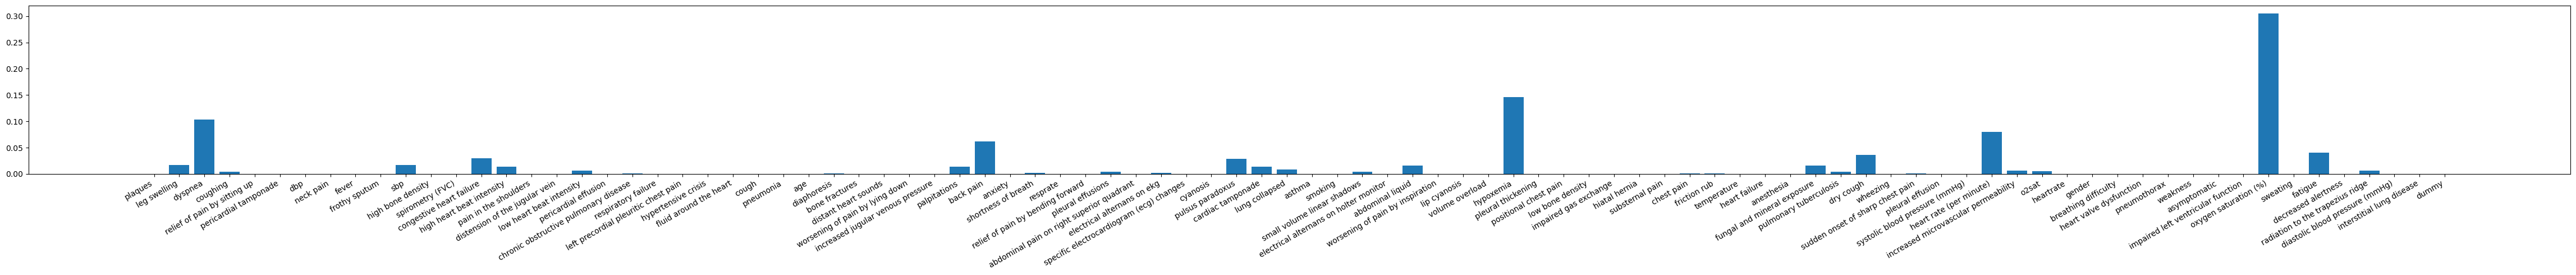

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.74754 |  0:00:00s
epoch 1  | loss: 1.26892 |  0:00:00s
epoch 2  | loss: 1.09741 |  0:00:00s
epoch 3  | loss: 0.88645 |  0:00:00s
epoch 4  | loss: 0.65376 |  0:00:00s
epoch 5  | loss: 0.64424 |  0:00:00s
epoch 6  | loss: 0.5181  |  0:00:00s
epoch 7  | loss: 0.56333 |  0:00:00s
epoch 8  | loss: 0.54933 |  0:00:00s
epoch 9  | loss: 0.50138 |  0:00:00s
epoch 10 | loss: 0.4218  |  0:00:00s
epoch 11 | loss: 0.44255 |  0:00:00s
epoch 12 | loss: 0.42314 |  0:00:00s
epoch 13 | loss: 0.42837 |  0:00:00s
epoch 14 | loss: 0.37428 |  0:00:00s
epoch 15 | loss: 0.37532 |  0:00:00s
epoch 16 | loss: 0.37136 |  0:00:00s
epoch 17 | loss: 0.31963 |  0:00:00s
epoch 18 | loss: 0.27595 |  0:00:00s
epoch 19 | loss: 0.2572  |  0:00:00s
epoch 20 | loss: 0.24012 |  0:00:00s
epoch 21 | loss: 0.19206 |  0:00:00s
epoch 22 | loss: 0.18658 |  0:00:00s
epoch 23 | loss: 0.20762 |  0:00:00s
epoch 24 | loss: 0.13607 |  0:00:00s
epoch 25 | loss: 0.14033 |  0:00:00s
epoch 26 | loss: 0.13316 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 11 | loss: 0.44255 |  0:00:00s
epoch 12 | loss: 0.42314 |  0:00:00s
epoch 13 | loss: 0.42837 |  0:00:00s
epoch 14 | loss: 0.37428 |  0:00:00s
epoch 15 | loss: 0.37532 |  0:00:00s
epoch 16 | loss: 0.37136 |  0:00:00s
epoch 17 | loss: 0.31963 |  0:00:00s
epoch 18 | loss: 0.27595 |  0:00:00s
epoch 19 | loss: 0.2572  |  0:00:00s
epoch 20 | loss: 0.24012 |  0:00:00s
epoch 21 | loss: 0.19206 |  0:00:00s
epoch 22 | loss: 0.18658 |  0:00:00s
epoch 23 | loss: 0.20762 |  0:00:00s
epoch 24 | loss: 0.13607 |  0:00:00s
epoch 25 | loss: 0.14033 |  0:00:00s
epoch 26 | loss: 0.13316 |  0:00:00s
epoch 27 | loss: 0.1435  |  0:00:00s
epoch 28 | loss: 0.12006 |  0:00:00s
epoch 29 | loss: 0.09571 |  0:00:00s
epoch 30 | loss: 0.07395 |  0:00:00s
epoch 31 | loss: 0.08907 |  0:00:00s
epoch 32 | loss: 0.06594 |  0:00:00s
epoch 33 | loss: 0.06961 |  0:00:00s
epoch 34 | loss: 0.05189 |  0:00:00s
epoch 35 | loss: 0.05124 |  0:00:00s
epoch 36 | loss: 0.05944 |  0:00:00s
epoch 37 | loss: 0.0676  |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 9  | loss: 0.50138 |  0:00:00s
epoch 10 | loss: 0.4218  |  0:00:00s
epoch 11 | loss: 0.44255 |  0:00:00s
epoch 12 | loss: 0.42314 |  0:00:00s
epoch 13 | loss: 0.42837 |  0:00:00s
epoch 14 | loss: 0.37428 |  0:00:00s
epoch 15 | loss: 0.37532 |  0:00:00s
epoch 16 | loss: 0.37136 |  0:00:00s
epoch 17 | loss: 0.31963 |  0:00:00s
epoch 18 | loss: 0.27595 |  0:00:00s
epoch 19 | loss: 0.2572  |  0:00:00s
epoch 20 | loss: 0.24012 |  0:00:00s
epoch 21 | loss: 0.19206 |  0:00:00s
epoch 22 | loss: 0.18658 |  0:00:00s
epoch 23 | loss: 0.20762 |  0:00:00s
epoch 24 | loss: 0.13607 |  0:00:00s
epoch 25 | loss: 0.14033 |  0:00:00s
epoch 26 | loss: 0.13316 |  0:00:00s
epoch 27 | loss: 0.1435  |  0:00:00s
epoch 28 | loss: 0.12006 |  0:00:00s
epoch 29 | loss: 0.09571 |  0:00:00s
epoch 30 | loss: 0.07395 |  0:00:00s
epoch 31 | loss: 0.08907 |  0:00:00s
epoch 32 | loss: 0.06594 |  0:00:00s
epoch 33 | loss: 0.06961 |  0:00:00s
epoch 34 | loss: 0.05189 |  0:00:00s
epoch 35 | loss: 0.05124 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 4  | loss: 0.65376 |  0:00:00s
epoch 5  | loss: 0.64424 |  0:00:00s
epoch 6  | loss: 0.5181  |  0:00:00s
epoch 7  | loss: 0.56333 |  0:00:00s
epoch 8  | loss: 0.54933 |  0:00:00s
epoch 9  | loss: 0.50138 |  0:00:00s
epoch 10 | loss: 0.4218  |  0:00:00s
epoch 11 | loss: 0.44255 |  0:00:00s
epoch 12 | loss: 0.42314 |  0:00:00s
epoch 13 | loss: 0.42837 |  0:00:00s
epoch 14 | loss: 0.37428 |  0:00:00s
epoch 15 | loss: 0.37532 |  0:00:00s
epoch 16 | loss: 0.37136 |  0:00:00s
epoch 17 | loss: 0.31963 |  0:00:00s
epoch 18 | loss: 0.27595 |  0:00:00s
epoch 19 | loss: 0.2572  |  0:00:00s
epoch 20 | loss: 0.24012 |  0:00:00s
epoch 21 | loss: 0.19206 |  0:00:00s
epoch 22 | loss: 0.18658 |  0:00:00s
epoch 23 | loss: 0.20762 |  0:00:00s
epoch 24 | loss: 0.13607 |  0:00:00s
epoch 25 | loss: 0.14033 |  0:00:00s
epoch 26 | loss: 0.13316 |  0:00:00s
epoch 27 | loss: 0.1435  |  0:00:00s
epoch 28 | loss: 0.12006 |  0:00:00s
epoch 29 | loss: 0.09571 |  0:00:00s
epoch 30 | loss: 0.07395 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 12 | loss: 0.42314 |  0:00:00s
epoch 13 | loss: 0.42837 |  0:00:00s
epoch 14 | loss: 0.37428 |  0:00:00s
epoch 15 | loss: 0.37532 |  0:00:00s
epoch 16 | loss: 0.37136 |  0:00:00s
epoch 17 | loss: 0.31963 |  0:00:00s
epoch 18 | loss: 0.27595 |  0:00:00s
epoch 19 | loss: 0.2572  |  0:00:00s
epoch 20 | loss: 0.24012 |  0:00:00s
epoch 21 | loss: 0.19206 |  0:00:00s
epoch 22 | loss: 0.18658 |  0:00:00s
epoch 23 | loss: 0.20762 |  0:00:00s
epoch 24 | loss: 0.13607 |  0:00:00s
epoch 25 | loss: 0.14033 |  0:00:00s
epoch 26 | loss: 0.13316 |  0:00:00s
epoch 27 | loss: 0.1435  |  0:00:00s
epoch 28 | loss: 0.12006 |  0:00:00s
epoch 29 | loss: 0.09571 |  0:00:00s
epoch 30 | loss: 0.07395 |  0:00:00s
epoch 31 | loss: 0.08907 |  0:00:00s
epoch 32 | loss: 0.06594 |  0:00:00s
epoch 33 | loss: 0.06961 |  0:00:00s
epoch 34 | loss: 0.05189 |  0:00:00s
epoch 35 | loss: 0.05124 |  0:00:00s
epoch 36 | loss: 0.05944 |  0:00:00s
epoch 37 | loss: 0.0676  |  0:00:00s
epoch 38 | loss: 0.03082 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 6  | loss: 0.5181  |  0:00:00s
epoch 7  | loss: 0.56333 |  0:00:00s
epoch 8  | loss: 0.54933 |  0:00:00s
epoch 9  | loss: 0.50138 |  0:00:00s
epoch 10 | loss: 0.4218  |  0:00:00s
epoch 11 | loss: 0.44255 |  0:00:00s
epoch 12 | loss: 0.42314 |  0:00:00s
epoch 13 | loss: 0.42837 |  0:00:00s
epoch 14 | loss: 0.37428 |  0:00:00s
epoch 15 | loss: 0.37532 |  0:00:00s
epoch 16 | loss: 0.37136 |  0:00:00s
epoch 17 | loss: 0.31963 |  0:00:00s
epoch 18 | loss: 0.27595 |  0:00:00s
epoch 19 | loss: 0.2572  |  0:00:00s
epoch 20 | loss: 0.24012 |  0:00:00s
epoch 21 | loss: 0.19206 |  0:00:00s
epoch 22 | loss: 0.18658 |  0:00:00s
epoch 23 | loss: 0.20762 |  0:00:00s
epoch 24 | loss: 0.13607 |  0:00:00s
epoch 25 | loss: 0.14033 |  0:00:00s
epoch 26 | loss: 0.13316 |  0:00:00s
epoch 27 | loss: 0.1435  |  0:00:00s
epoch 28 | loss: 0.12006 |  0:00:00s
epoch 29 | loss: 0.09571 |  0:00:00s
epoch 30 | loss: 0.07395 |  0:00:00s
epoch 31 | loss: 0.08907 |  0:00:00s
epoch 32 | loss: 0.06594 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 3  | loss: 0.88645 |  0:00:00s
epoch 4  | loss: 0.65376 |  0:00:00s
epoch 5  | loss: 0.64424 |  0:00:00s
epoch 6  | loss: 0.5181  |  0:00:00s
epoch 7  | loss: 0.56333 |  0:00:00s
epoch 8  | loss: 0.54933 |  0:00:00s
epoch 9  | loss: 0.50138 |  0:00:00s
epoch 10 | loss: 0.4218  |  0:00:00s
epoch 11 | loss: 0.44255 |  0:00:00s
epoch 12 | loss: 0.42314 |  0:00:00s
epoch 13 | loss: 0.42837 |  0:00:00s
epoch 14 | loss: 0.37428 |  0:00:00s
epoch 15 | loss: 0.37532 |  0:00:00s
epoch 16 | loss: 0.37136 |  0:00:00s
epoch 17 | loss: 0.31963 |  0:00:00s
epoch 18 | loss: 0.27595 |  0:00:00s
epoch 19 | loss: 0.2572  |  0:00:00s
epoch 20 | loss: 0.24012 |  0:00:00s
epoch 21 | loss: 0.19206 |  0:00:00s
epoch 22 | loss: 0.18658 |  0:00:00s
epoch 23 | loss: 0.20762 |  0:00:00s
epoch 24 | loss: 0.13607 |  0:00:00s
epoch 25 | loss: 0.14033 |  0:00:00s
epoch 26 | loss: 0.13316 |  0:00:00s
epoch 27 | loss: 0.1435  |  0:00:00s
epoch 28 | loss: 0.12006 |  0:00:00s
epoch 29 | loss: 0.09571 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 6  | loss: 0.5181  |  0:00:00s
epoch 7  | loss: 0.56333 |  0:00:00s
epoch 8  | loss: 0.54933 |  0:00:00s
epoch 9  | loss: 0.50138 |  0:00:00s
epoch 10 | loss: 0.4218  |  0:00:00s
epoch 11 | loss: 0.44255 |  0:00:00s
epoch 12 | loss: 0.42314 |  0:00:00s
epoch 13 | loss: 0.42837 |  0:00:00s
epoch 14 | loss: 0.37428 |  0:00:00s
epoch 15 | loss: 0.37532 |  0:00:00s
epoch 16 | loss: 0.37136 |  0:00:00s
epoch 17 | loss: 0.31963 |  0:00:00s
epoch 18 | loss: 0.27595 |  0:00:00s
epoch 19 | loss: 0.2572  |  0:00:00s
epoch 20 | loss: 0.24012 |  0:00:00s
epoch 21 | loss: 0.19206 |  0:00:00s
epoch 22 | loss: 0.18658 |  0:00:00s
epoch 23 | loss: 0.20762 |  0:00:00s
epoch 24 | loss: 0.13607 |  0:00:00s
epoch 25 | loss: 0.14033 |  0:00:00s
epoch 26 | loss: 0.13316 |  0:00:00s
epoch 27 | loss: 0.1435  |  0:00:00s
epoch 28 | loss: 0.12006 |  0:00:00s
epoch 29 | loss: 0.09571 |  0:00:00s
epoch 30 | loss: 0.07395 |  0:00:00s
epoch 31 | loss: 0.08907 |  0:00:00s
epoch 32 | loss: 0.06594 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 5  | loss: 0.64424 |  0:00:00s
epoch 6  | loss: 0.5181  |  0:00:00s
epoch 7  | loss: 0.56333 |  0:00:00s
epoch 8  | loss: 0.54933 |  0:00:00s
epoch 9  | loss: 0.50138 |  0:00:00s
epoch 10 | loss: 0.4218  |  0:00:00s
epoch 11 | loss: 0.44255 |  0:00:00s
epoch 12 | loss: 0.42314 |  0:00:00s
epoch 13 | loss: 0.42837 |  0:00:00s
epoch 14 | loss: 0.37428 |  0:00:00s
epoch 15 | loss: 0.37532 |  0:00:00s
epoch 16 | loss: 0.37136 |  0:00:00s
epoch 17 | loss: 0.31963 |  0:00:00s
epoch 18 | loss: 0.27595 |  0:00:00s
epoch 19 | loss: 0.2572  |  0:00:00s
epoch 20 | loss: 0.24012 |  0:00:00s
epoch 21 | loss: 0.19206 |  0:00:00s
epoch 22 | loss: 0.18658 |  0:00:00s
epoch 23 | loss: 0.20762 |  0:00:00s
epoch 24 | loss: 0.13607 |  0:00:00s
epoch 25 | loss: 0.14033 |  0:00:00s
epoch 26 | loss: 0.13316 |  0:00:00s
epoch 27 | loss: 0.1435  |  0:00:00s
epoch 28 | loss: 0.12006 |  0:00:00s
epoch 29 | loss: 0.09571 |  0:00:00s
epoch 30 | loss: 0.07395 |  0:00:00s
epoch 31 | loss: 0.08907 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.74754 |  0:00:00s
epoch 1  | loss: 1.26892 |  0:00:00s
epoch 2  | loss: 1.09741 |  0:00:00s
epoch 3  | loss: 0.88645 |  0:00:00s
epoch 4  | loss: 0.65376 |  0:00:00s
epoch 5  | loss: 0.64424 |  0:00:00s
epoch 6  | loss: 0.5181  |  0:00:00s
epoch 7  | loss: 0.56333 |  0:00:00s
epoch 8  | loss: 0.54933 |  0:00:00s
epoch 9  | loss: 0.50138 |  0:00:00s
epoch 10 | loss: 0.4218  |  0:00:00s
epoch 11 | loss: 0.44255 |  0:00:00s
epoch 12 | loss: 0.42314 |  0:00:00s
epoch 13 | loss: 0.42837 |  0:00:00s
epoch 14 | loss: 0.37428 |  0:00:00s
epoch 15 | loss: 0.37532 |  0:00:00s
epoch 16 | loss: 0.37136 |  0:00:00s
epoch 17 | loss: 0.31963 |  0:00:00s
epoch 18 | loss: 0.27595 |  0:00:00s
epoch 19 | loss: 0.2572  |  0:00:00s
epoch 20 | loss: 0.24012 |  0:00:00s
epoch 21 | loss: 0.19206 |  0:00:00s
epoch 22 | loss: 0.18658 |  0:00:00s
epoch 23 | loss: 0.20762 |  0:00:00s
epoch 24 | loss: 0.13607 |  0:00:00s
epoch 25 | loss: 0.14033 |  0:00:00s
epoch 26 | loss: 0.13316 |  0:00:00s
e

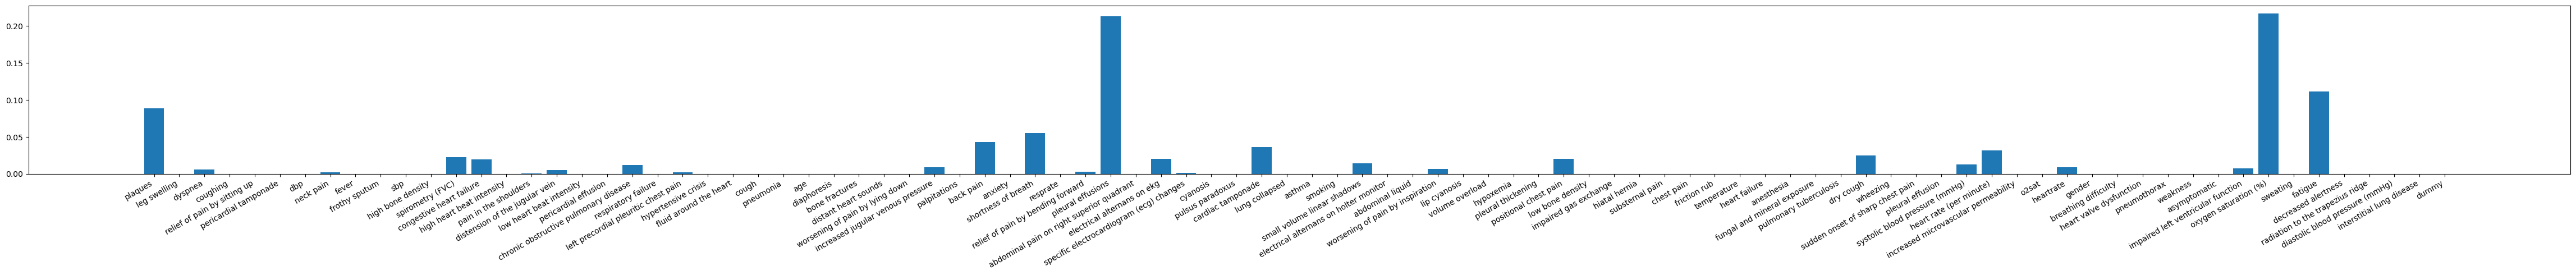

In [16]:
import os
from pytorch_tabnet.tab_model import TabNetClassifier

save_folder = os.path.join("generated", "aug_results")
prefix = "[single-lesion] [with-doc] [tabnet]"

result_df = []
features_sets = {
    "original": {
        "df": original_df,
        "cols": original_clinical_cols,
    },
    "augmented": {
        "df": merged_df,
        "cols": list(set(extended_clinical_features)),
    },
}
models = {
    # "DecisionTree": DecisionTreeClassifier,
    # "RandomForest": RandomForestClassifier,
    # "XGBoost": xgb.XGBClassifier,
    "TabNet": TabNetClassifier
}

for f_k, f_v in features_sets.items():
    for m_k, m_v in models.items():
        for l in TOP5_LABEL_COLS:
            result = get_summary(
                f_v["df"],
                f_v["cols"] + ["dummy"],
                l,
                m_v,
            )

            # append the dataframe
            # save fig
            # raise StopIteration()
            result["fi_fig"].savefig(os.path.join(save_folder, f"{prefix} [{f_k}][{m_k}][{l}].png"))
            result_df.append(
                OrderedDict(
                    {
                        "Feature Set": f_k,
                        "Model": m_k,
                        "Lesion": l,
                        "Accuracy": result["accuracy"],
                        "AUC": result["AUC"],
                        "#fi>dummy": result["#fi>dummy"],
                        "fi>dummy": result["fi>dummy"],
                    }
                )
            )

In [19]:
pd.DataFrame(result_df)

Feature Set   Model                       Lesion           Accuracy  \
0    original  TabNet              Pulmonary edema  0.681818±0.000000   
1    original  TabNet  Enlarged cardiac silhouette  0.673913±0.000000   
2    original  TabNet                Consolidation  0.600000±0.000000   
3    original  TabNet                  Atelectasis  0.750000±0.000000   
4    original  TabNet          Pleural abnormality  0.538462±0.000000   
5   augmented  TabNet              Pulmonary edema  0.681818±0.000000   
6   augmented  TabNet  Enlarged cardiac silhouette  0.956522±0.000000   
7   augmented  TabNet                Consolidation  0.900000±0.000000   
8   augmented  TabNet                  Atelectasis  0.863636±0.000000   
9   augmented  TabNet          Pleural abnormality  0.820513±0.000000   

                 AUC  #fi>dummy  \
0  0.652381±0.000000          4   
1  0.683236±0.000000          6   
2  0.607655±0.000000          5   
3  0.763393±0.000000          2   
4  0.562500±0.000000          8   
5  0.652381±0.000000         22   
6  0.955166±0.000000         52   
7  0.921053±0.000000          3   
8  0.866071±0.000000         47   
9  0.829167±0.000000         39   

                                            fi>dummy  
0            [temperature, heartrate, resprate, age]  
1     [temperature, heartrate, o2sat, sbp, dbp, age]  
2                  [resprate, sbp, dbp, age, gender]  
3                           [temperature, heartrate]  
4  [temperature, heartrate, resprate, o2sat, sbp,...  
5  [coughing, fever, fluid around the heart, back...  
6  [dyspnea, coughing, dbp, neck pain, sbp, spiro...  
7      [pneumonia, dry cough, oxygen saturation (%)]  
8  [leg swelling, dyspnea, coughing, relief of pa...  
9  [plaques, leg swelling, dyspnea, relief of pai...

In [20]:
pd.DataFrame(result_df).to_csv(os.path.join(save_folder, "{prefix} result.csv"))